In [1]:
# System libraries:
%load_ext autoreload
import pandas as pd
import json
import nltk
import numpy as np
import os
import sys
from IPython.core.interactiveshell import InteractiveShell
from pymystem3 import Mystem
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from datetime import datetime
import re
import gensim.downloader as api
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
InteractiveShell.ast_node_interactivity = "all"

In [97]:
def get_corpus_tfidf(documents):
    dictionary = Dictionary(documents)
    n_items = len(dictionary)
    corpus = [dictionary.doc2bow(text) for text in documents]
    tfidf = TfidfModel(corpus)
    return tfidf[corpus], dictionary


def get_tf_idf_counts(series):
    tf_idf_flattened = [b for a in series for b in a if not type(a) == float]
    counts = Counter(tf_idf_flattened)
    return counts

def yearly_counts(word_list):
    counts = Counter(word_list)
    return counts



def get_top_words(corpus_tfidf, dictionary):
    top_words_series = pd.Series(index=range(0,len(corpus_tfidf)))
    top_words_series.name = 'tf_idf_words'
    for i, row in enumerate(corpus_tfidf):
        # sort the list
        sorted_by_second = sorted(row, key=lambda tup: tup[1])
        # get the top 20 elements
        a = np.array(sorted_by_second[-20:], dtype=np.int32)
        # get the first indices
        idx = a[:,0].tolist()
        #dictionary[a[:,0].tolist()]
        article_top_words = [dictionary[i] for i in idx]
        top_words_series.iloc[i] = article_top_words
        
    return top_words_series


def output_wordcloud(counts, title = None, save_image = False, path = 'generated_images/'):
    cloud = WordCloud(stopwords=None, background_color='white', width=2400, height=1800
                     ).generate_from_frequencies(counts)

    plt.figure(figsize=(30,18))
    if title:
        plt.title(title, fontsize=90)
    plt.imshow(cloud)
    plt.axis('off')
    if save_image and title:
        plt.savefig(path + title + ".png")
    plt.show()

def print_yearly_wordclouds(tfidf_data, prefix):
    for year in sorted(tfidf_data.year.unique()):
        yearly_data = tfidf_data[tfidf_data['year'] == year].tf_idf_words
        counts = get_tf_idf_counts(yearly_data)
        title = prefix + str(year)
        output_wordcloud(counts, title, True)

In [10]:
data = pd.read_csv('data/processed/yle_fi_merged_new.csv')
data = data.drop(data[data.headline=='headline'].index)

In [14]:
data.lemmas_content = data.lemmas_content.apply(eval)

In [23]:
# clear lemmas from special characters:
stop_words = stopwords.words('finnish') + list(string.punctuation) 
re_cleanup = re.compile('(^quot$|^lt$|^gt$|^II$|^\/.*|^http.*|^ .*|^www|^-.*|.*[0-9].*|\?|\.|^\&.*|.*-$|^lude$|^lisä$|\\n|^[A-Z]$|\*|\_|\'|\"|\`|nbsp|^.$|mdash|^Ag$|^Co|^Bank|Inc)', re.IGNORECASE)

def remove_stop_words(word_list):
    filtered_sentence = [w.lower() for w in word_list if not w in stop_words and not re_cleanup.match(w)]
    return filtered_sentence

# Replace list - Putti - Putin

def extract_year(s):
    year = None
    try:
        year = datetime.strptime(s[:10], '%Y-%m-%d').year
    except ValueError:
        pass
    
    return int(year)

In [17]:
cleaned_lemmas = data.lemmas_content.apply(remove_stop_words)

In [21]:
data.lemmas_content = cleaned_lemmas

In [24]:
data['year'] = data['timePublished'].apply(extract_year)

In [25]:
data

headline  \
0      Kaukasian konflikti: Aseissa Georgia ja Venäjä...   
1               Otteita Venäjän-tuntijoiden vastauksista   
2            Etelä-Ossetian ruutitynnyri räjähti viimein   
3      Yle Uutiset seuraa Ukrainan kriisiä hetki hetk...   
4                      Saksan ulkopolitiikan täyskäännös   
5                      Viennin rasvatahra: käsikirjoitus   
6      Näkökulma: "Venäjä, Venäjä, Venäjä" – Suomen k...   
7                       Venäjä-Suomi minuutti minuutilta   
8                 Näin Suomi voitti Venäjän rankkareilla   
9               Jääkiekon MM-finaali minuutti minuutilta   
10               Näin Suomi voitti Venäjän MM-välierässä   
11     Hakkeri masinoi verkkohyökkäyksiä Venäjää vast...   
12          Venäjä aikoo iskeä kipeästi Turkin talouteen   
13         Ukrainan kriisi hetki hetkeltä tiistaina 4.3.   
14     Vaiettu vaino - Venäjän lainsuojattomat tshets...   
15     Analyysi: Mitä peliä Venäjä oikein pelaa – suu...   
16     Venäjän "pehmeä voima" huolestuttaa Latviassa:...   
17     Analyysi: Onko Donald Trump "Mantšurian kandid...   
18     Venäjän sota jatkuu Syyriassa – Joukkoja Suome...   
19     Kultarannan ulko- ja turvallisuuspoliittinen k...   
20     Ukrainalaisaktivisti Ylelle: Venäjä sieppasi, ...   
21              Oleg ja Maša saivat uuden selän Suomesta   
22         Krimin tilanne hetki hetkeltä torstaina 27.2.   
23          Kapellimestari Gergijev puhuu Venäjän suulla   
24     Analyysi: Venäläinen ajattelee, että virolaise...   
25                         Alkaako kylmä sota uudelleen?   
26     Etelä-Ossetian konflikti viilentää suhteita Ve...   
27     Analyysi: 4 syytä, joiden takia Venäjä kiinnos...   
28     Miten Venäjä suhtautuu naapureihinsa? Raportti...   
29     Vladimir Putinin suora kyselytunti hetki hetkeltä   
...                                                  ...   
68449            Tolonen ja Seppänen voittoon Kalajoella   
68450              Antti Ruuskanen kiskaisi keihäshopeaa   
68451  Kiekonheiton olympiakakkonen kärähti dopingist...   
68452  YIT käynnistää yli tuhannen asunnon hankkeen B...   
68453         Kiviranta neljäs triathlonissa Hollannissa   
68454  Nadal teki 134 miljoonan euron arvoista tennis...   
68455                  Djokovic sai arvokasta lepoaikaa    
68456                     Italialainen Maresca Sevillaan   
68457  Turvapaikanhakijalapset imevät oppia sienen la...   
68458              Tre Kronor odottaa kovia vahvistuksia   
68459                  Montenegron Nato-jäsenyys lähellä   
68460                              Pietarin porsaanleike   
68461                    Lemmikkieläintehtailu kiihtynyt   
68462                                   Joensuun kartano   
68463  Outoja tutkimusmenetelmiä ja mystisiä merkintö...   
68464  Pienempi pakkauskoko hämärtää luomuruuan tuntu...   
68465                        Kun Suomi kaatoi Punakoneen   
68466               USA:n kiekkonaisten boikottiuhka ohi   
68467  Ovetshkin dominoi Minnesotaa ylivoimalla - ura...   
68468  Siperian tuhannet arvoitukselliset metaanikupl...   
68469  Millanen ol' Viipuri? Muistoja ja kuvia vanhas...   
68470  Udmurtiassa uhrataan muinaisjumalille ja seura...   
68471              Marjo Matikainen hiihti olympiakultaa   
68472                     Yhteinen sävel: Moskovan valot   
68473                      Keskiviikko 29.3.2017 (radio)   
68474          Emmi Peltonen jäi ulos MM-vapaaohjelmasta   
68475  Analyysi: Supo yrittää pitää suomalaiset agent...   
68476  Suomi siirtyi ydinenergiaan itänaapurista tila...   
68477                 Jani Saxell: Huomispäivän vartijat   
68478                          Onko Suomi tasa-arvoinen?   

                                                    lead  \
0      Kaukasiassa Georgian ja siitä eroon pyrkivän E...   
1      Tähän tiivistelmään on koottu otteita asiantun...   
2      Perjantaina 8. elokuuta 2008 pitkään jännittyn...   
3      Venäjän duuma käsittelee tänään Krimin ja Seva...   
4      Tuskin mikään muu Eu

In [ ]:
#data = data.drop(data[data['year'].isna()].index)

In [29]:
data = data.drop('lead', 1)

In [33]:
data = data.rename({'text':'content'}, axis=1)

In [35]:
data.index.name = 'id'

In [37]:
data.to_csv('data/processed/yle_fi_lemmas_new.csv', header = True, index = True)

In [ ]:
data = pd.read_csv('data/processed/yle_fi_lemmas_new.csv', index_col = 0, converters = {'lemmas_content' : eval})
data.iloc[:5]

In [38]:
yle_fi_tfidf, yle_fi_dictionary = get_corpus_tfidf(data.lemmas_content)
top_words_yle_fi = get_top_words(yle_fi_tfidf, yle_fi_dictionary)
yle_fi_tfidf_data = pd.concat([data['year'], top_words_yle_fi], axis = 1)
# drop rows where tfidf is nan
yle_fi_tfidf_data = yle_fi_tfidf_data.drop(yle_fi_tfidf_data[yle_fi_tfidf_data.year.isnull()].index)

In [47]:
yle_fi_tfidf_data.year = yle_fi_tfidf_data.year.apply(int)

In [48]:
# drop rows where tfidf is nan
yle_fi_tfidf_data = yle_fi_tfidf_data.drop(yle_fi_tfidf_data[yle_fi_tfidf_data.tf_idf_words.isnull()].index)


In [49]:
yle_fi_tfidf_data.to_csv('data/processed/yle_fi_tfidf_new.csv')

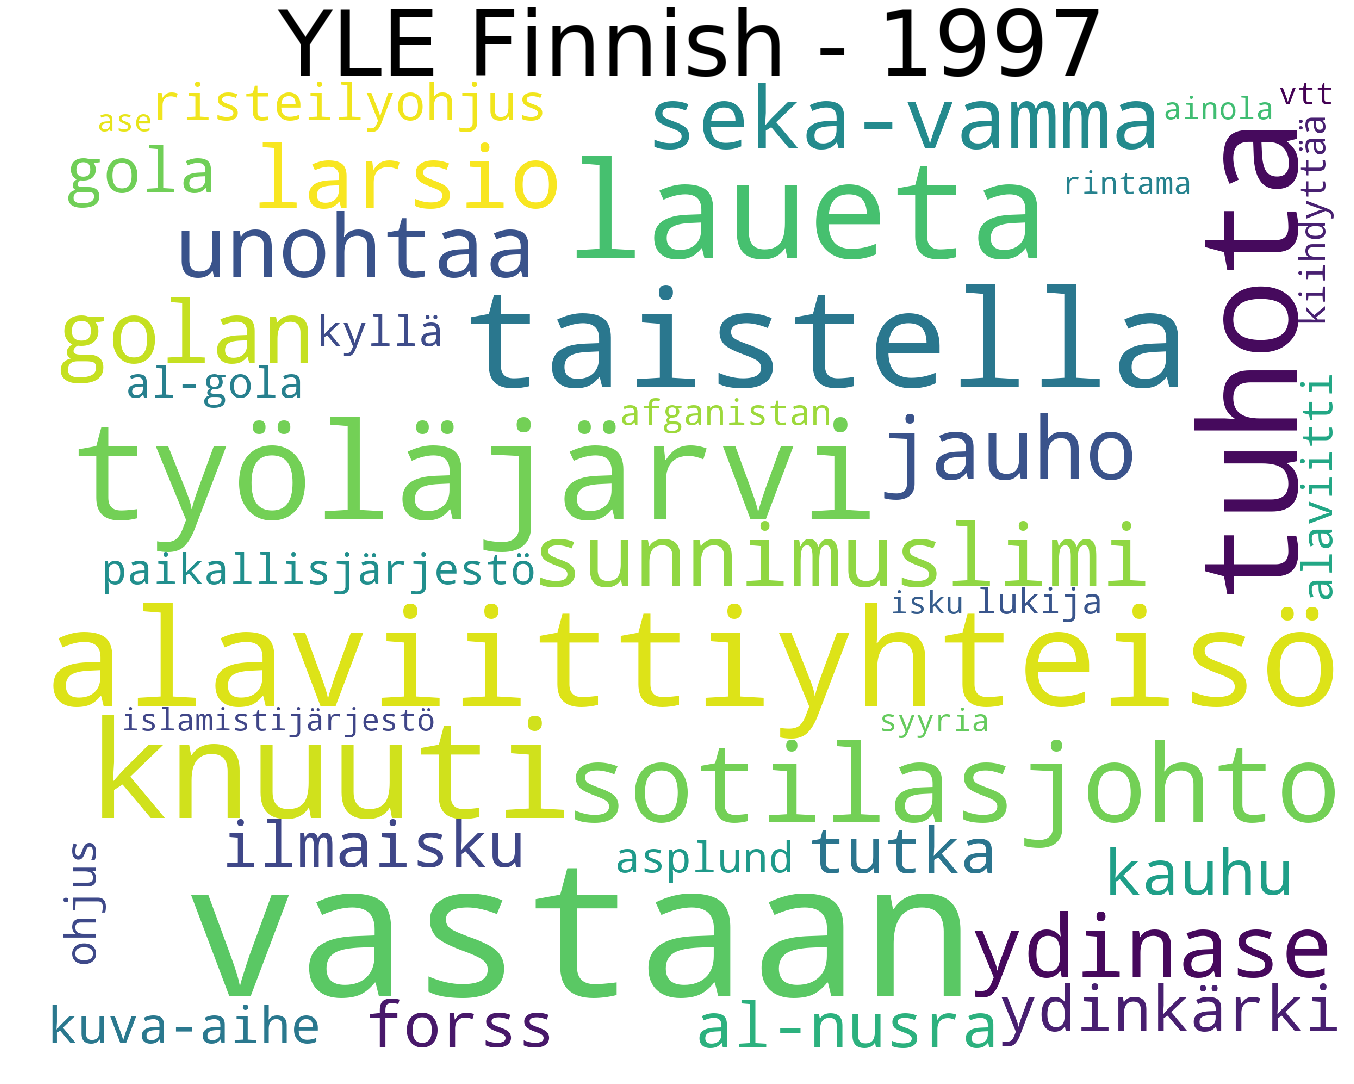

KeyboardInterrupt: 

In [63]:
print_yearly_wordclouds(yle_fi_tfidf_data, "YLE Finnish - ")

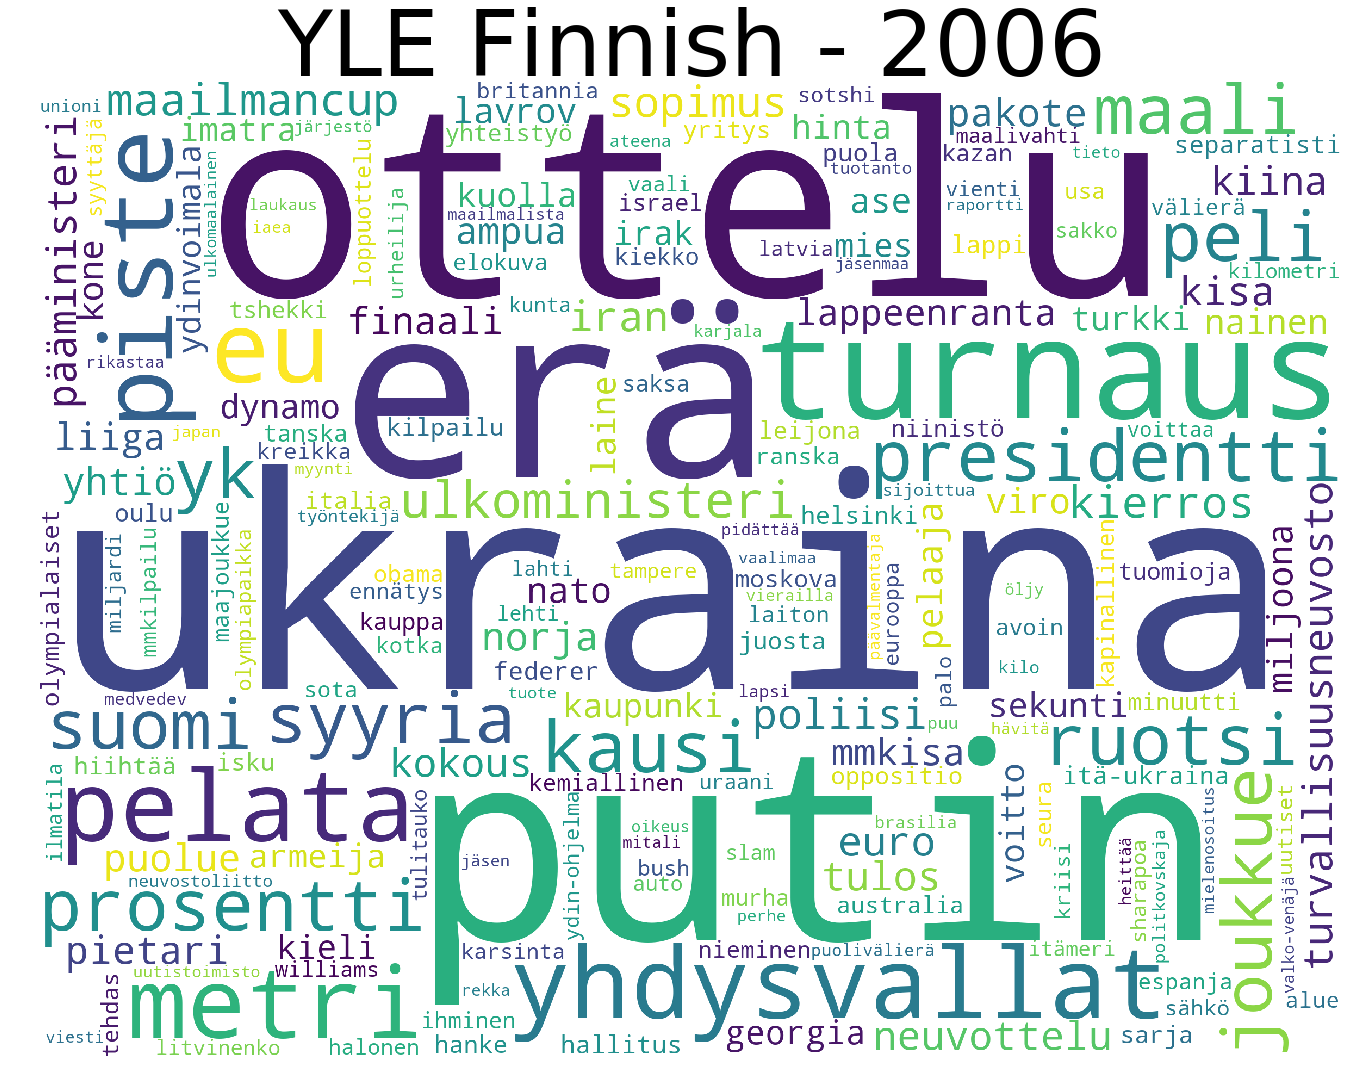

KeyboardInterrupt: 

In [61]:
years = [2006, 2008, 2010]

for year in years:
    prefix = "YLE Finnish - "
    tfidf_data = yle_fi_tfidf_data

    yearly_data = tfidf_data[tfidf_data['year'] == year].tf_idf_words
    counts = get_tf_idf_counts(yearly_data)  
    title = prefix + str(year)
    output_wordcloud(counts, title,  True)

In [85]:
lemmas_by_year = pd.Series(name = 'lemmas', index = sorted(data.year.unique()))

In [86]:
#populate yearly data
for year in lemmas_by_year.index:
    lemmas_by_year[year] = list(data[data.year == year].lemmas_content.values)[0]



In [87]:
lemmas_by_year

1997    [pommi, naapuri, uhata, venäjä, ydinase, suomi...
1998    [vienti, rasvatahra, käsikirjoitus, nummela:, ...
1999    [itämafia, nousu, heroiini, ottaa, pietari, ot...
2000    [latvia, sysätä, venäjä, todellinen, ahdinko, ...
2001    [venäjä, nöyryyttää, koripallonainen, lauantai...
2002    [vaieta, vaino, venäjä, lainsuojaton, tshetshe...
2003    [leijona, hävitä, venäjä, jatkoaika, suomi, jä...
2004    [eu, tukea, venäjä, wto-jäsenyy, eurooppa, uni...
2005    [kylmänen, sota, terrorismi, vastainen, taiste...
2006    [venäjä, poliittinen, murha, venäjä, maine, ko...
2007    [ote, venäjätuntija, vastaus, tiivistelmä, koo...
2008    [kaukasia, konflikti, asi, georg, venäjä, tuke...
2009    [itä-eurooppa, ohjuskilpihanke, hylkäys, lukea...
2010    [venäjä-suomi, minuutti, minuutti, suomi, jääk...
2011    [näin, suomi, voittaa, venäjä, rankkari, suomi...
2012    [venäjä-slovakia, minuutti, minuutti, seuranta...
2013    [punainen, määräys, käsikirjoitus, viime, helm...
2014    [yle, 

In [90]:
# Run tf-idf on yearly data
yle_fi_tfidf_yearly, yle_fi_dictionary_yearly = get_corpus_tfidf(lemmas_by_year)
top_words_yle_fi_yearly = get_top_words(yle_fi_tfidf_yearly, yle_fi_dictionary_yearly)

# drop rows where tfidf is nan
#yle_fi_tfidf_data = yle_fi_tfidf_data.drop(yle_fi_tfidf_data[yle_fi_tfidf_data.year.isnull()].index)

In [91]:
top_words_yle_fi_yearly 

0     [sotilasjohto, stefan, vtt, suomi, risteilyohj...
1     [kauppalasku, vienti, suomi, selitys, kuljetta...
2     [gramma, peltoniemi, selin, sonck, ylinenkoski...
3     [ottelu, jäljellä, katu, maalivahti, pelata, j...
4     [ihan, pistää, edessä, lauantai, jolloin, voit...
5     [vlasov, länsimaa, viranomainen, kansallisuus,...
6     [tshekki, pelata, ruotsi, puoliväli, leijona, ...
7     [vientihinta, vähentäminen, vähitellen, wto-jä...
8     [tuottaa, aseistaa, ase, iso-britannia, lähi-i...
9     [raportti, laki, tshetshenia, lähialue, maine,...
10    [russia, hoitaa, etu, kehitys, is, vastaaja, v...
11    [saakashvili, tbilisi, vanhanen, tunnustaa, ta...
12    [barack, poikkeama, tutkija, hanke, aleksanter...
13    [hietanen, jokinen, kaksiminuuttinen, kontiola...
14    [päättyy:, jatkoaika, kakkonen, pelata, alivoi...
15    [turnaus, malkin, malkki, varlamov, purkaa, pa...
16    [red, you, luovuttaa, of, oikeusministeriö, oi...
17    [kannattaa, aikoa, liittää, oikeus, tunnus

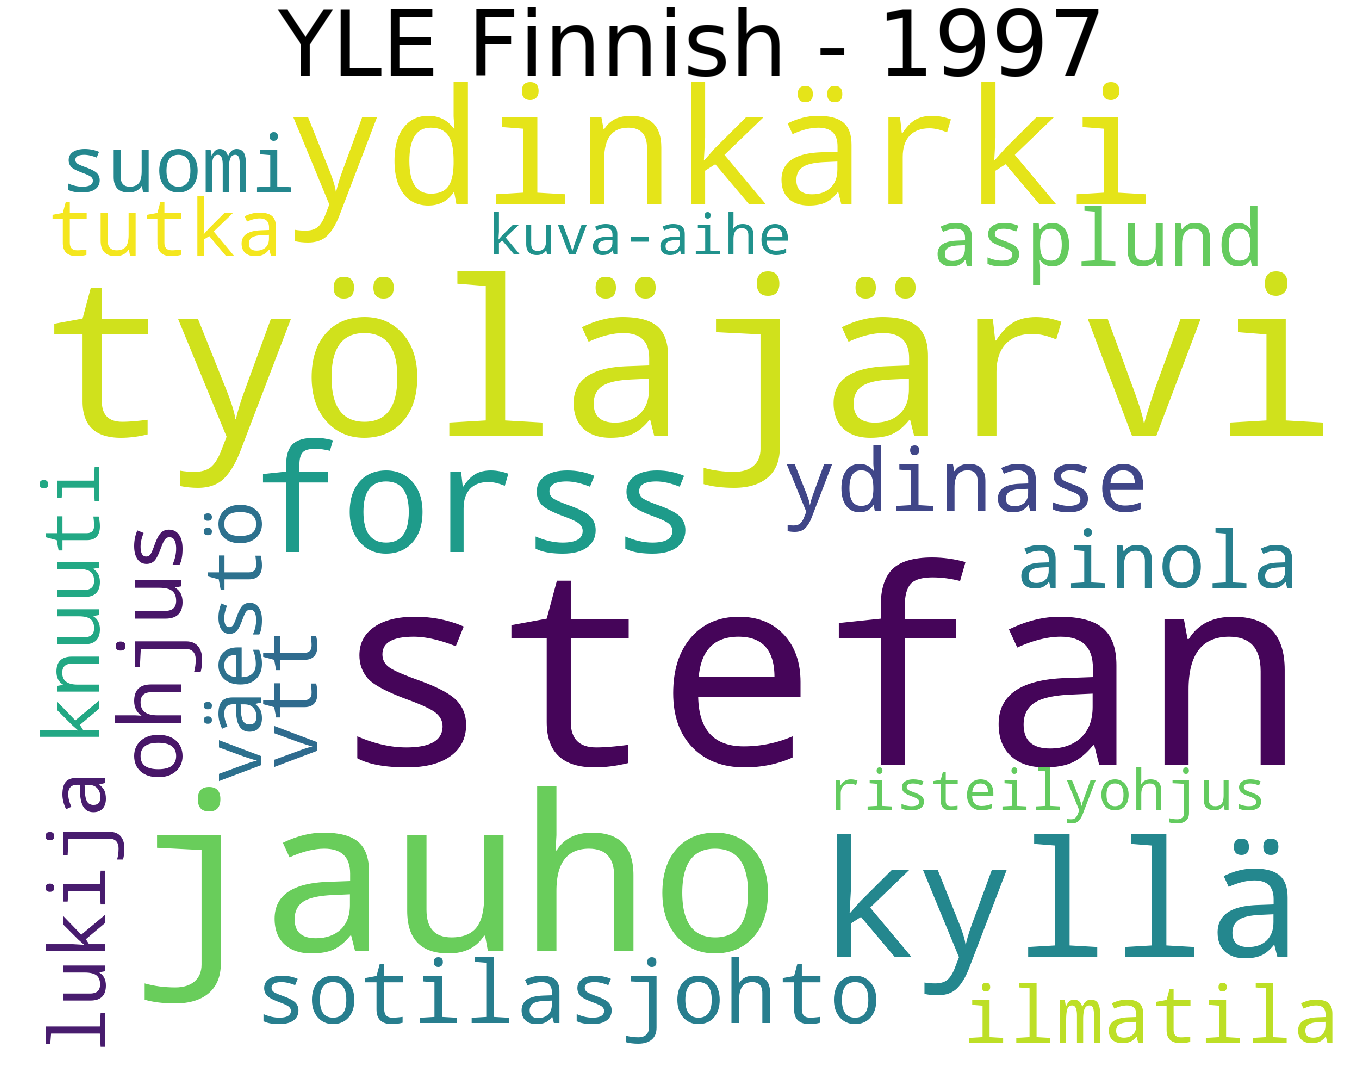

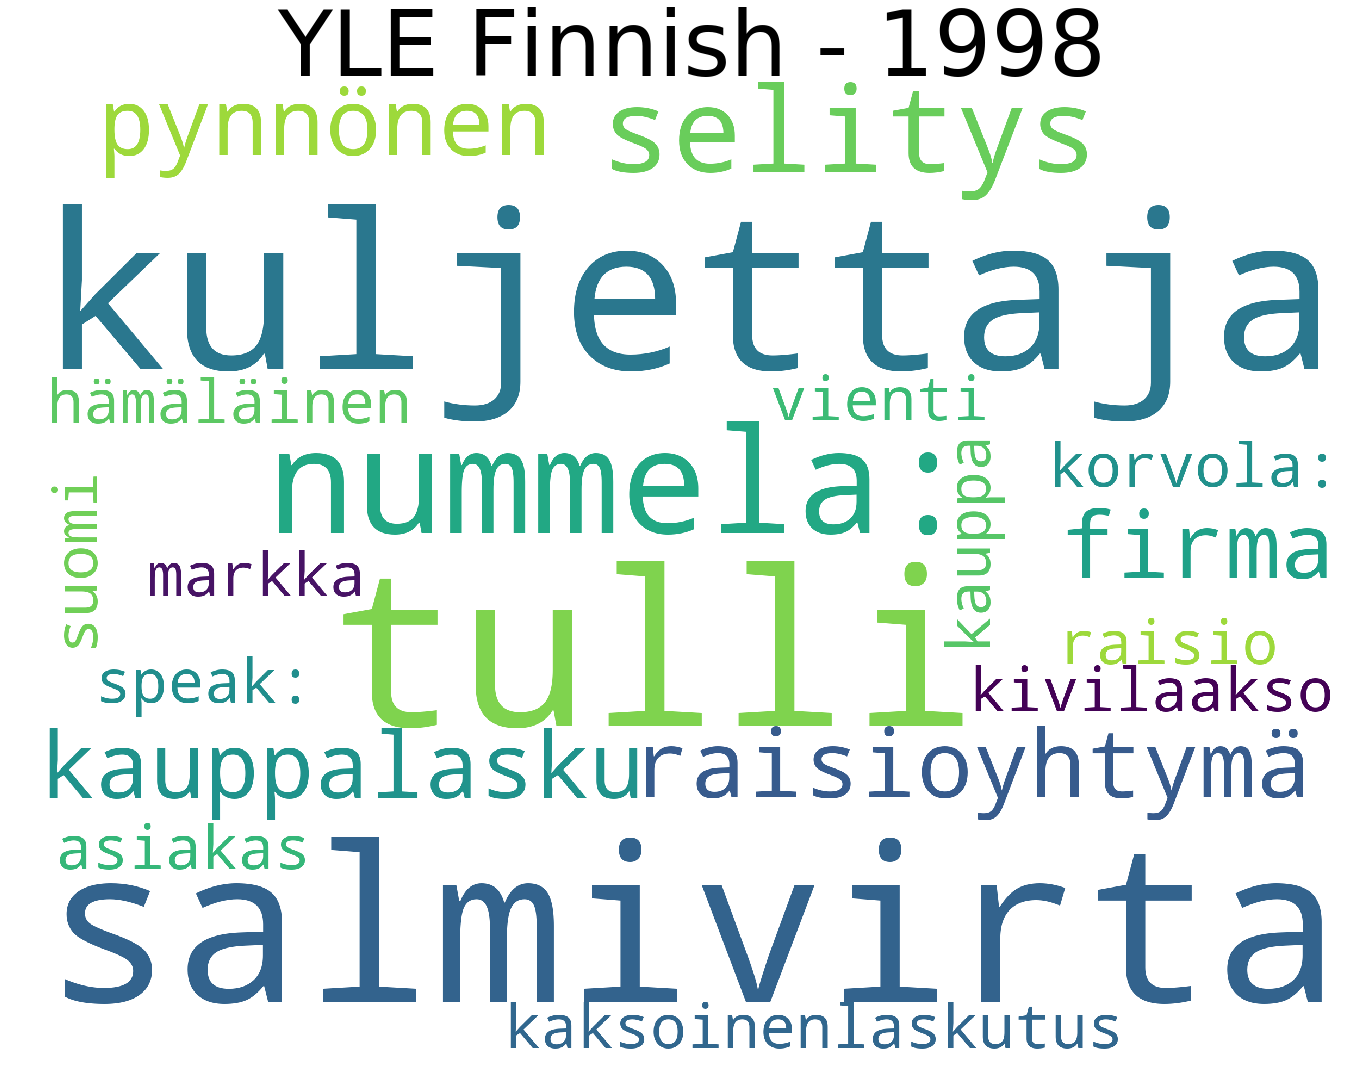

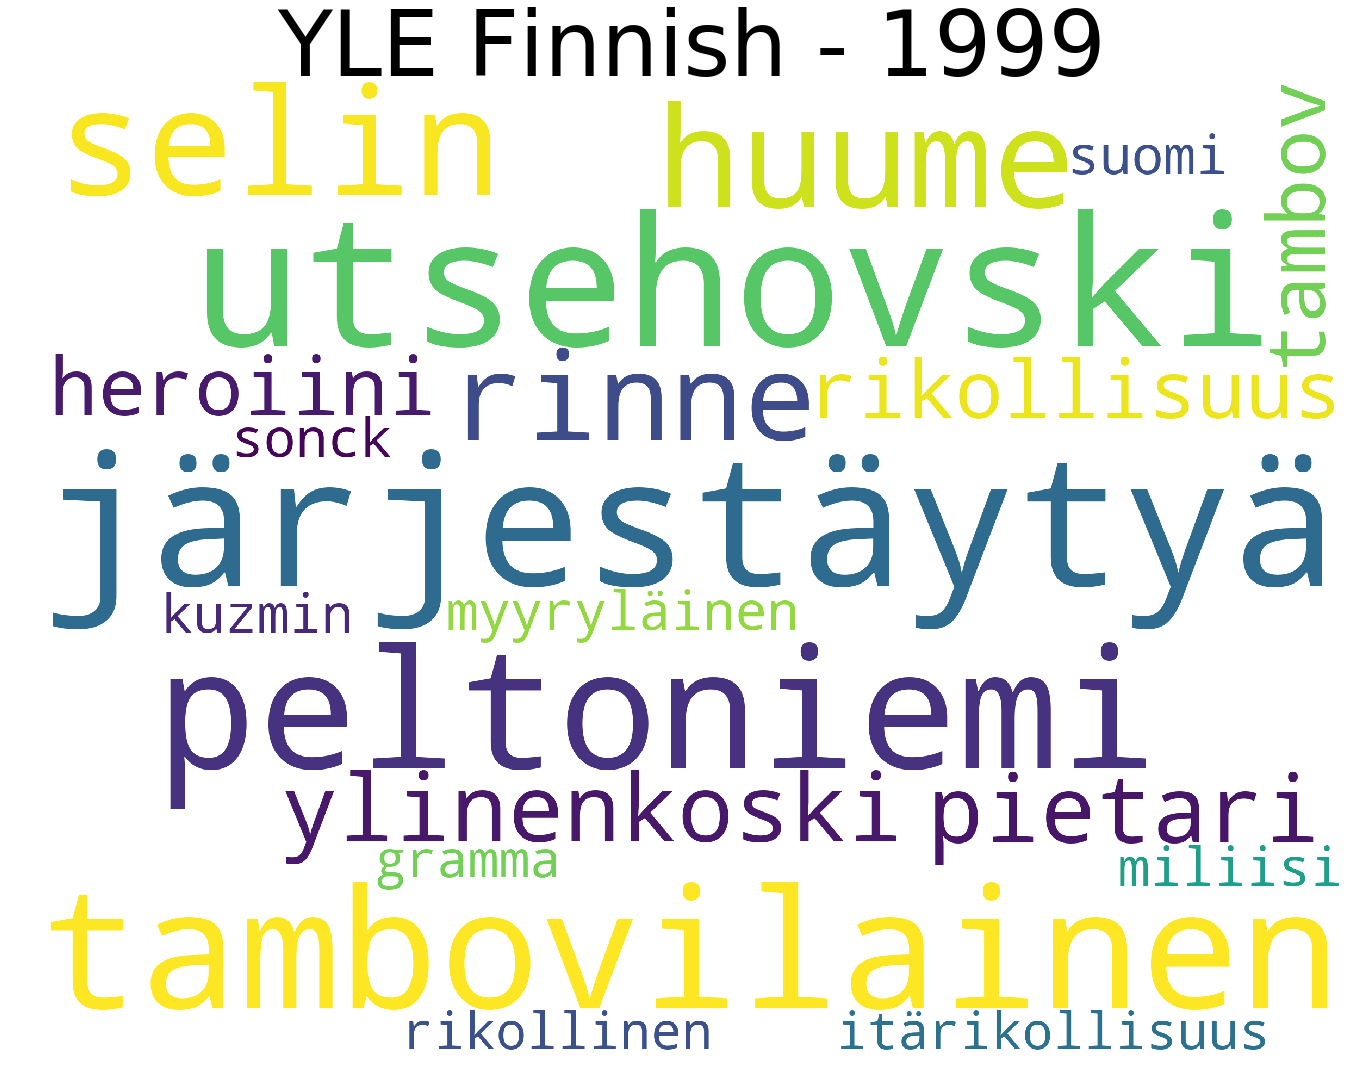

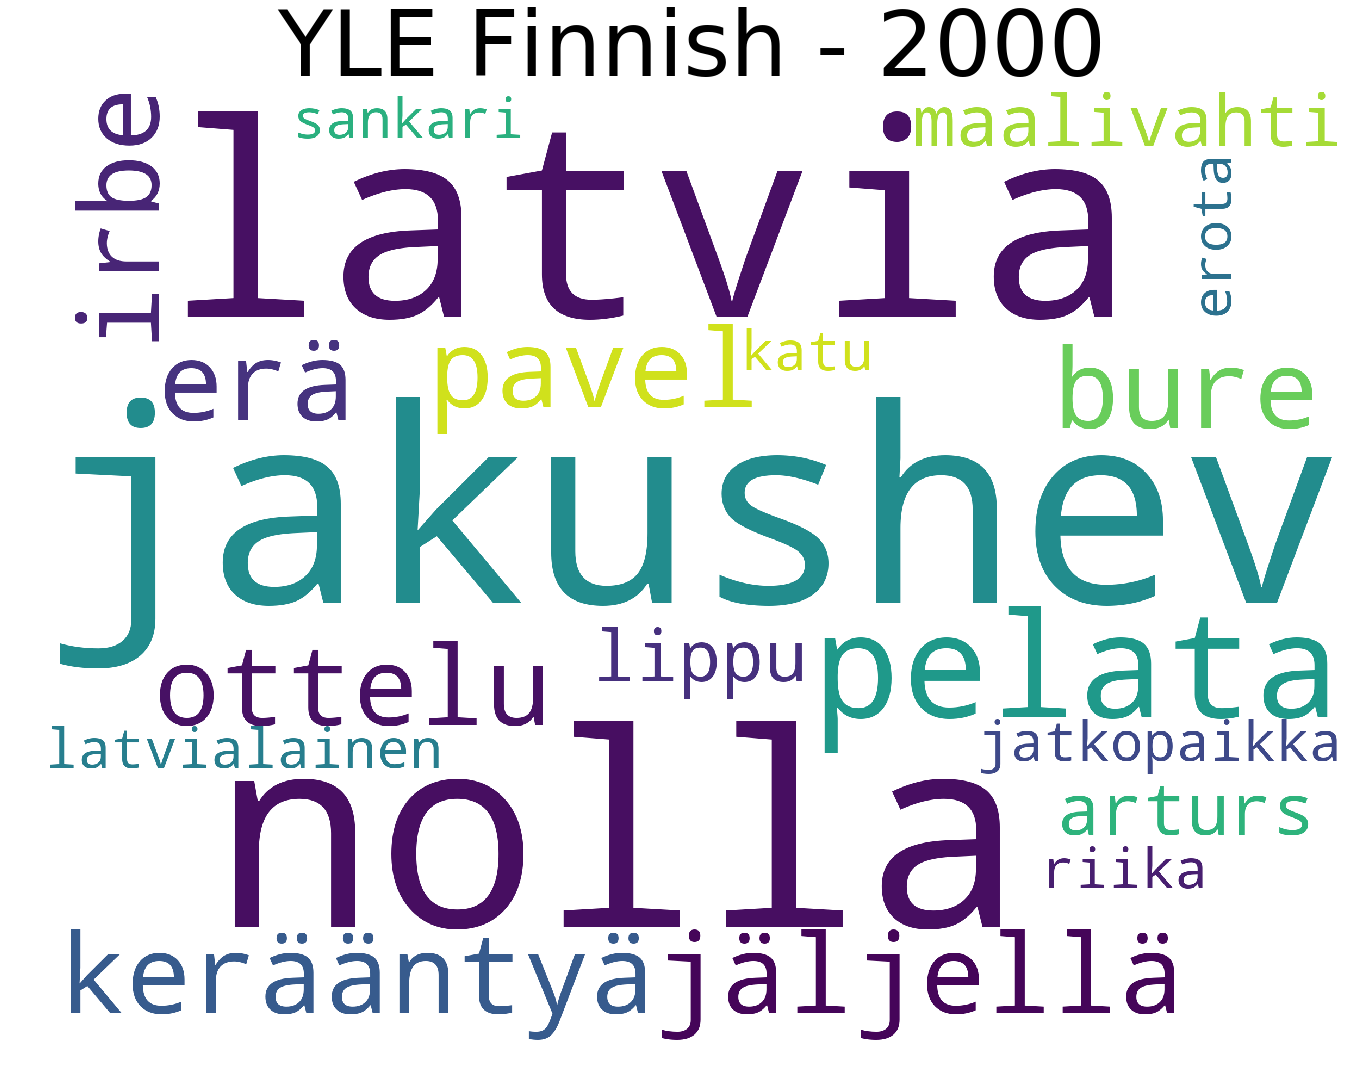

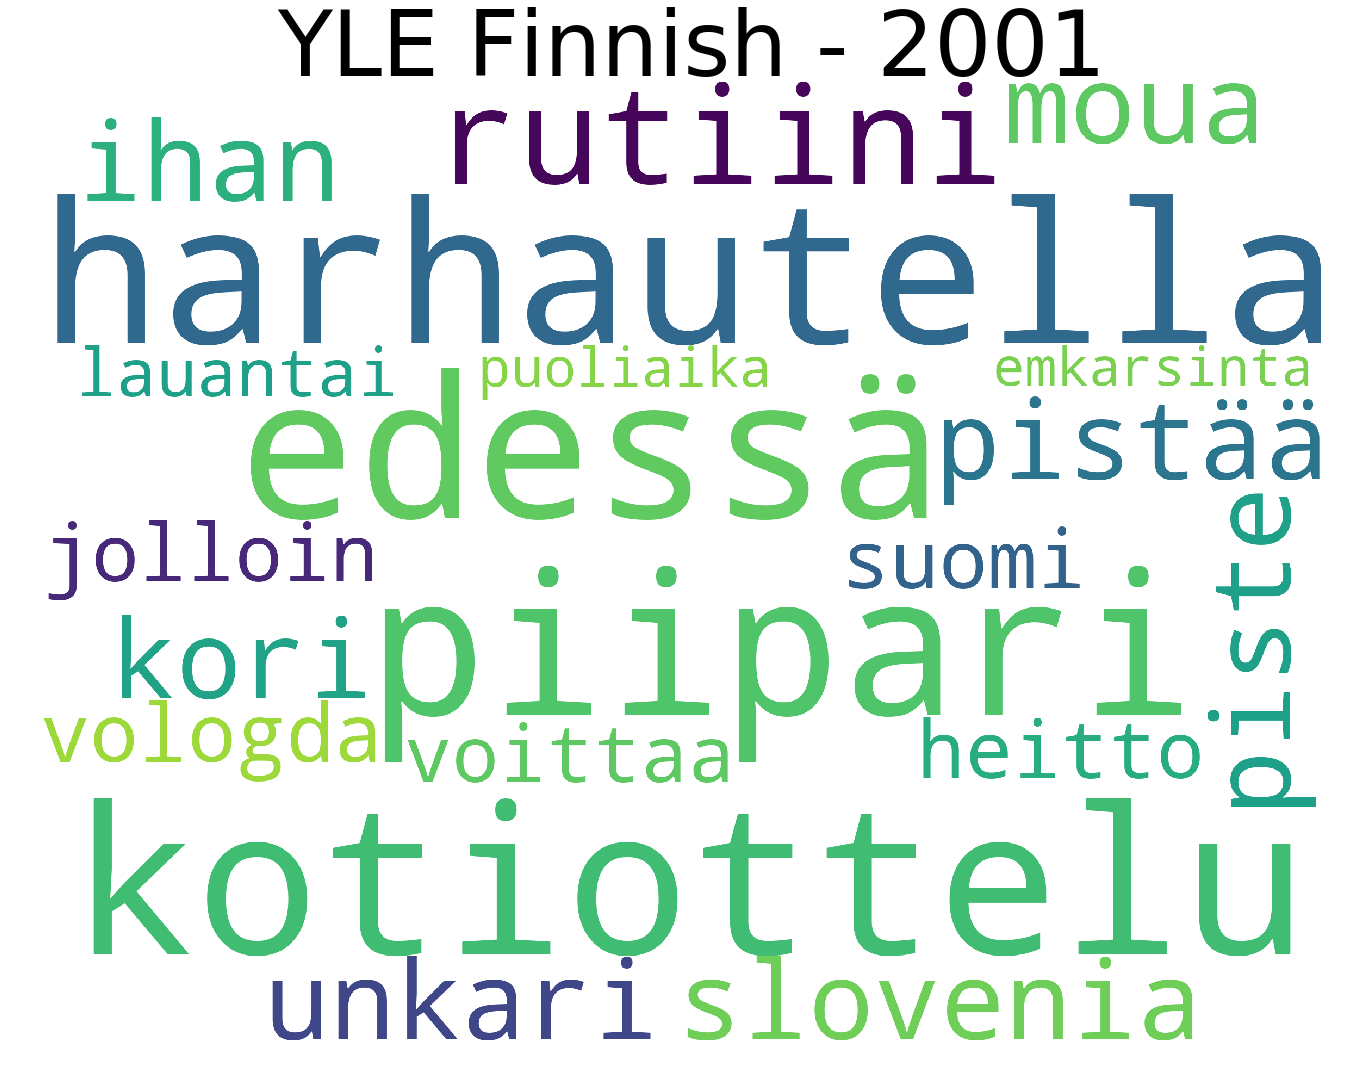

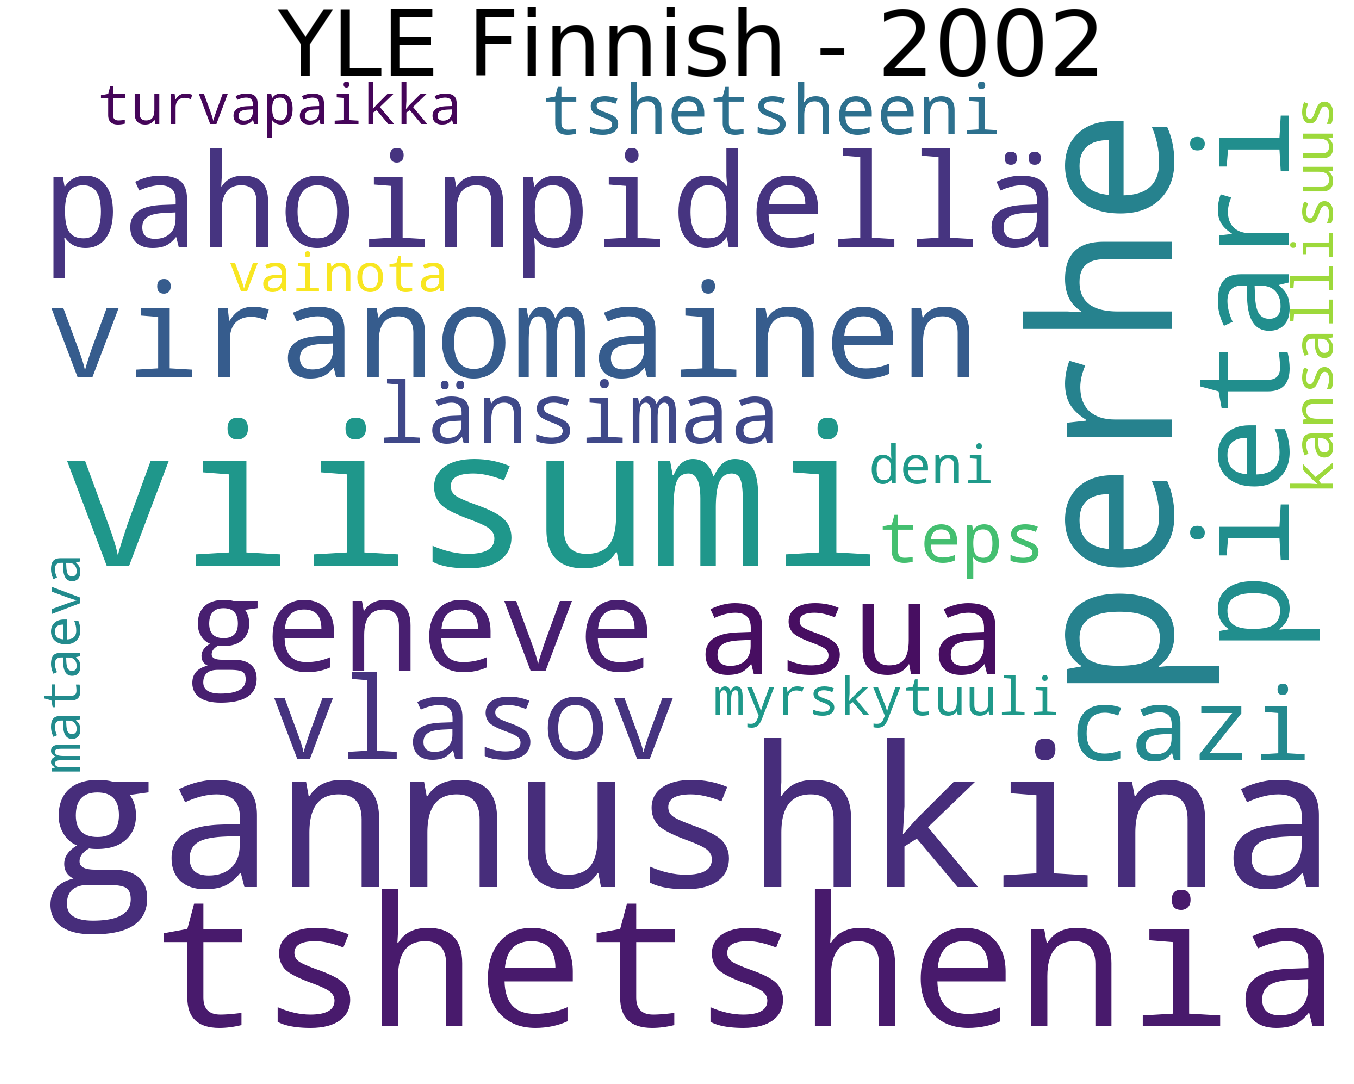

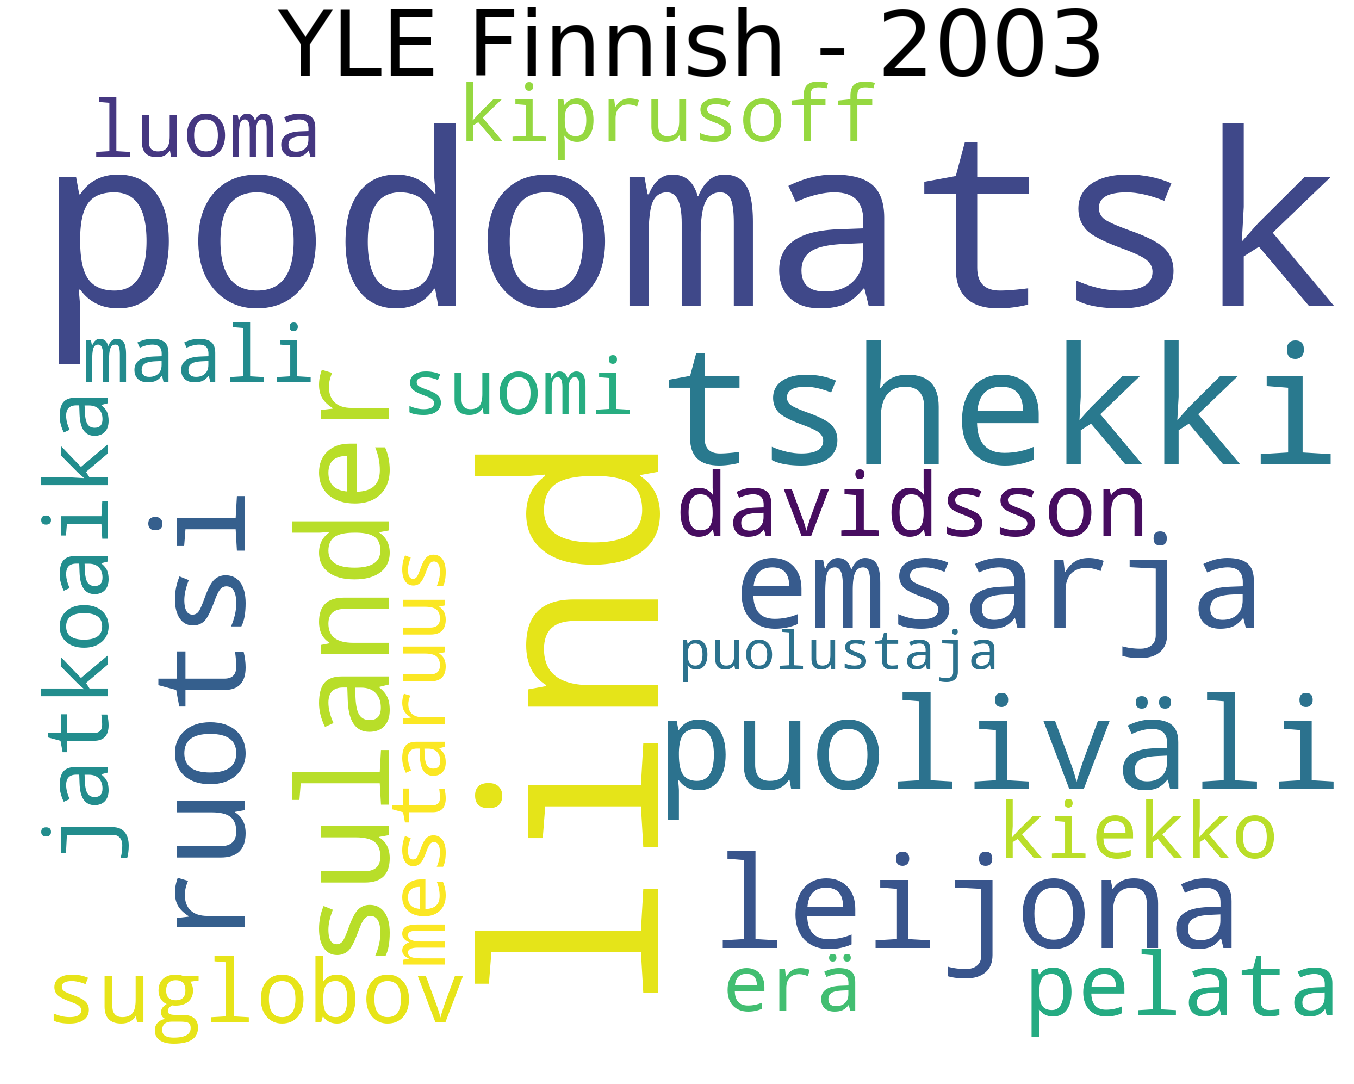

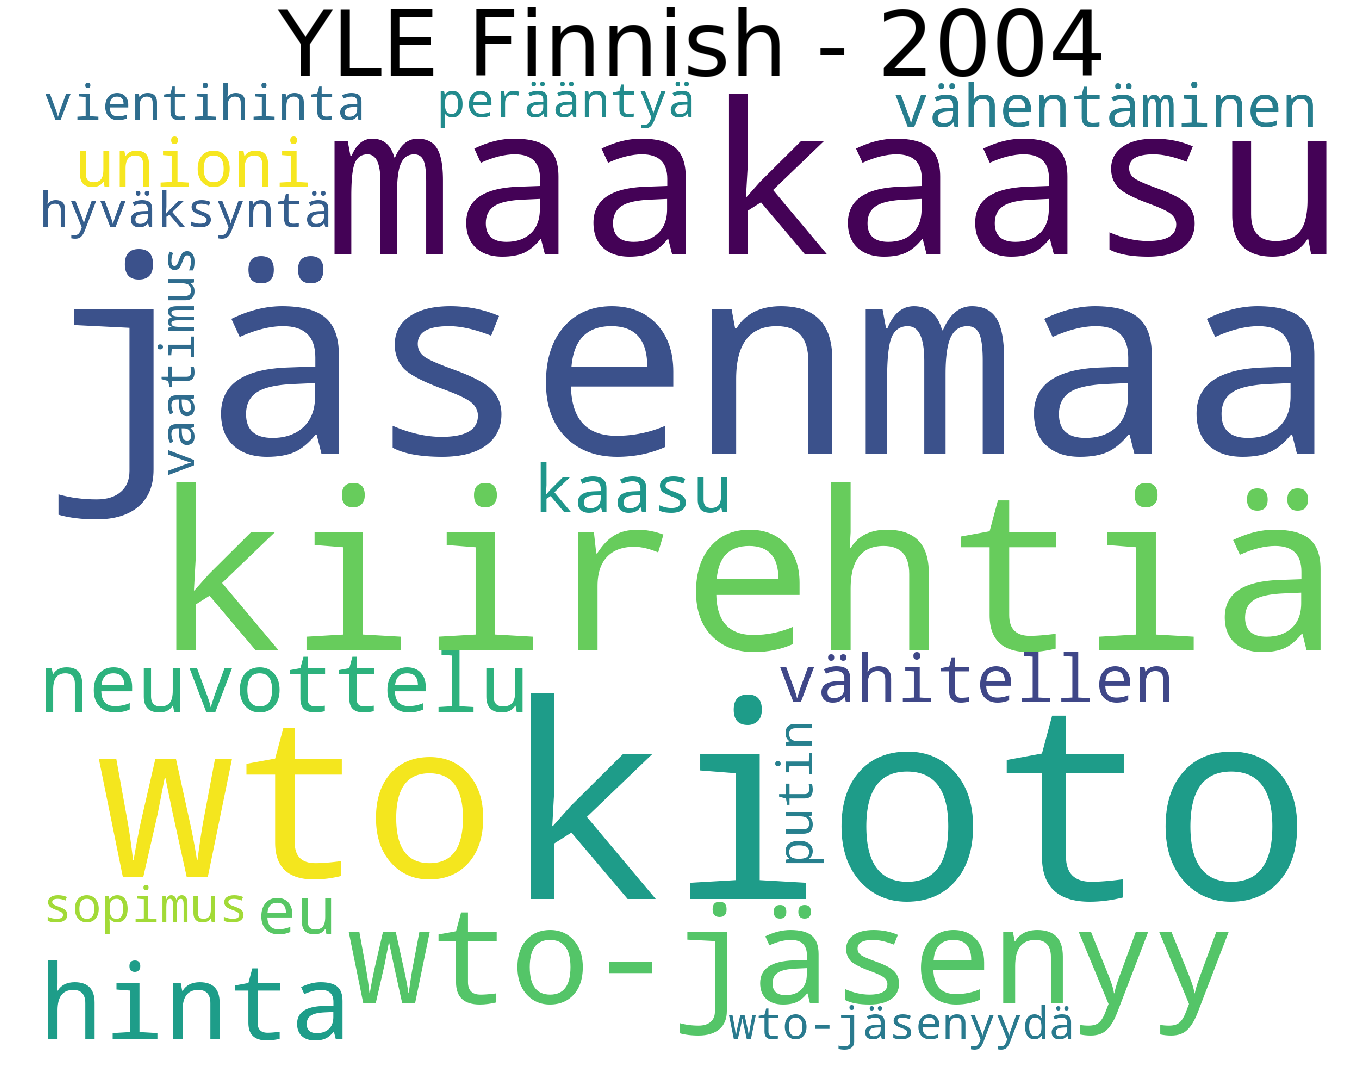

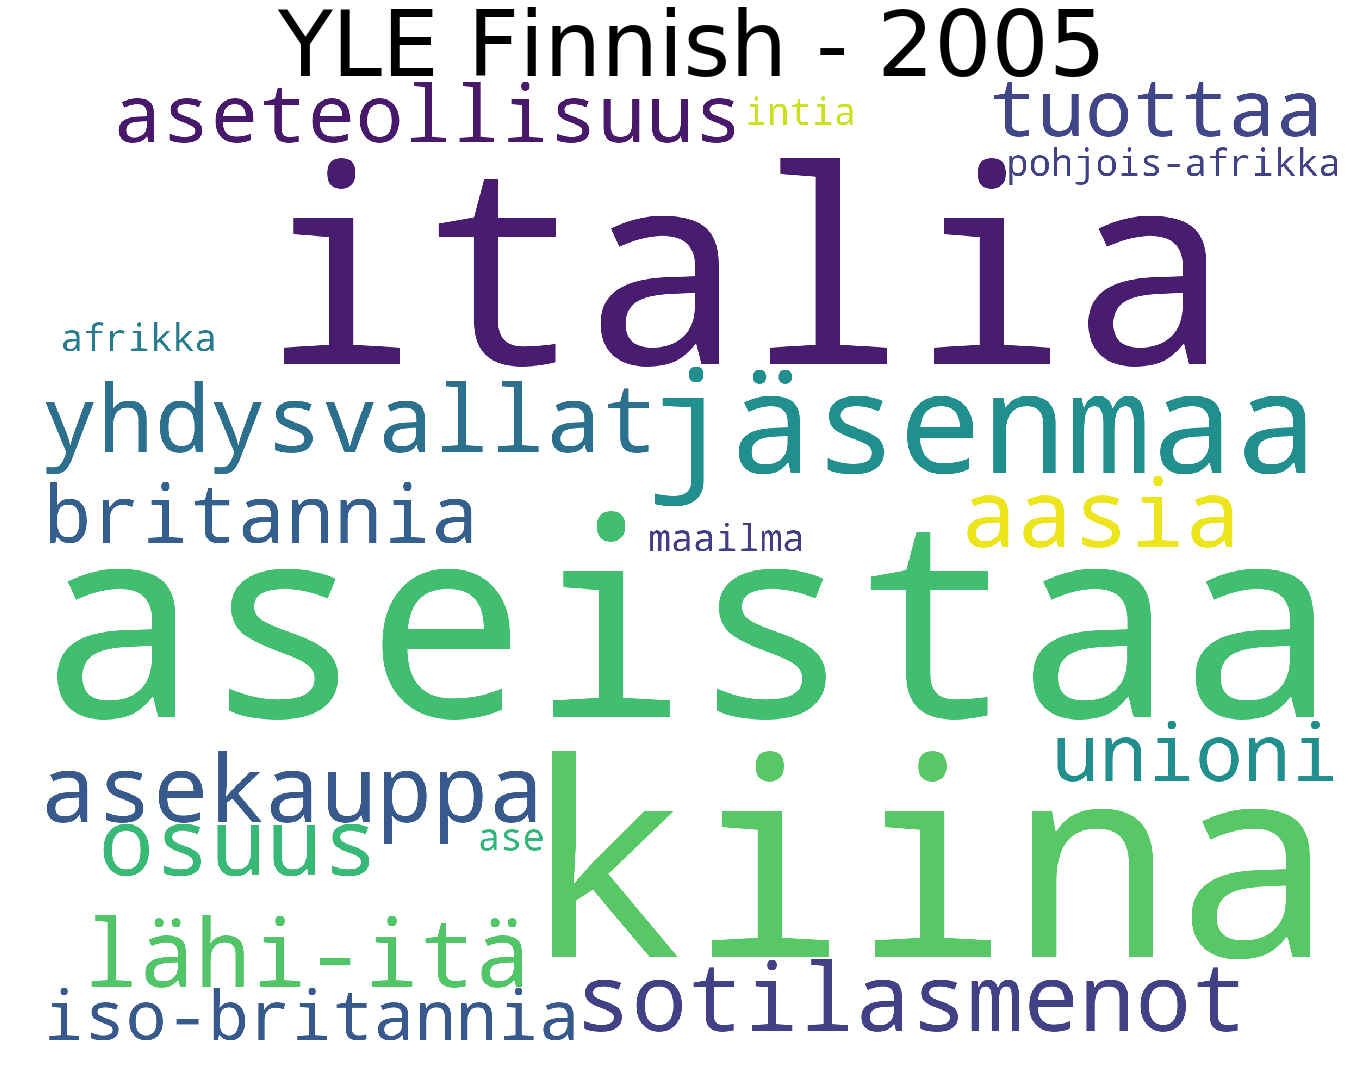

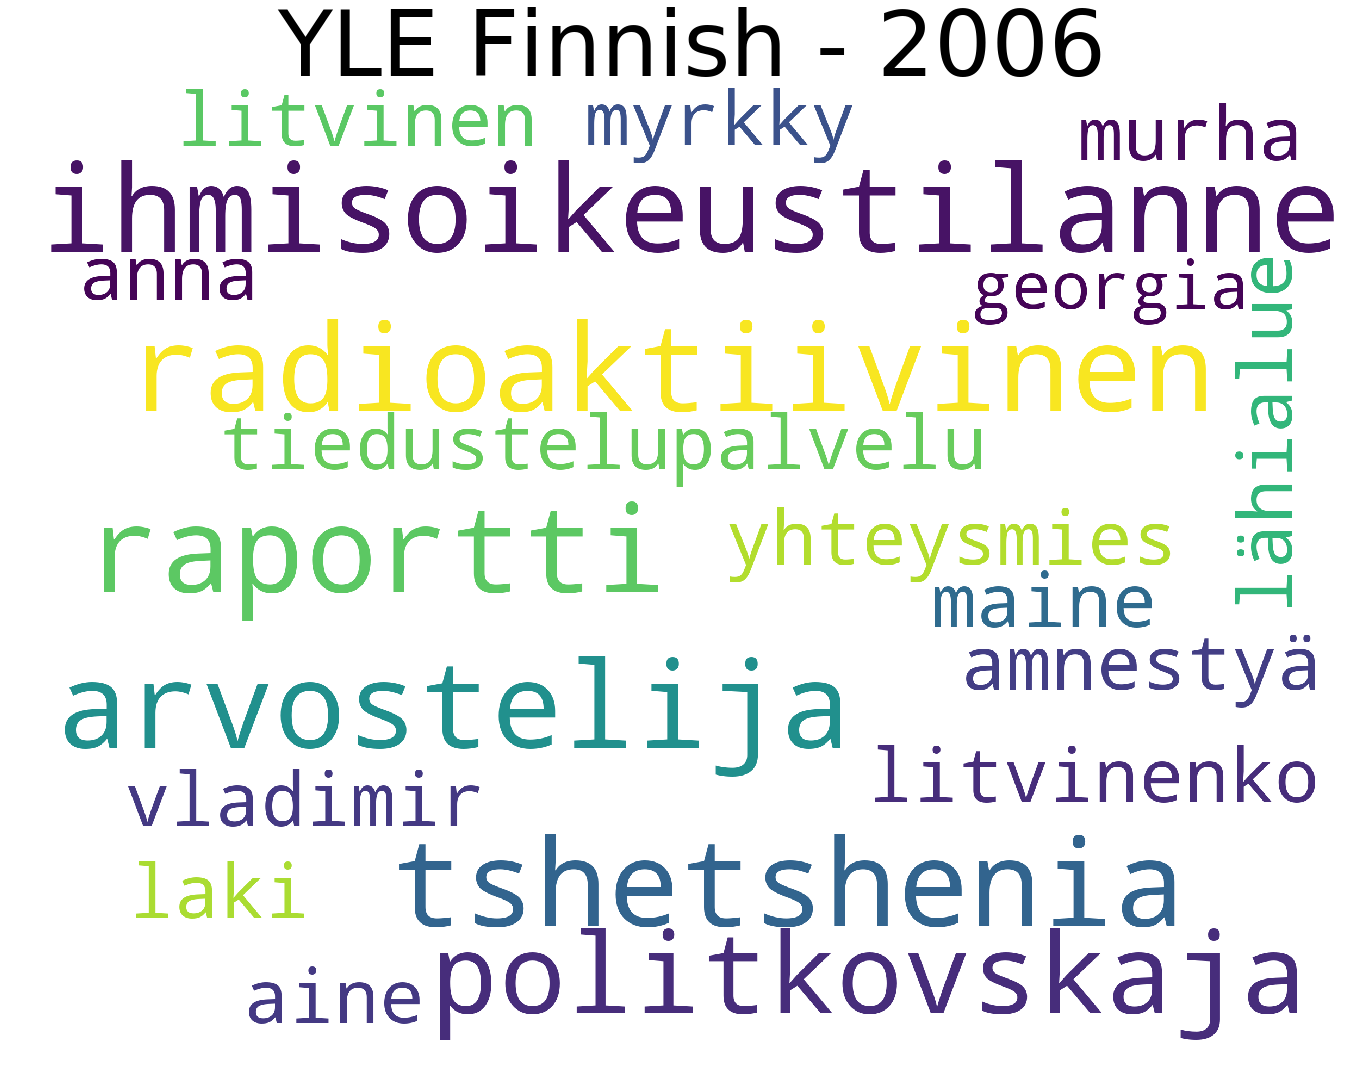

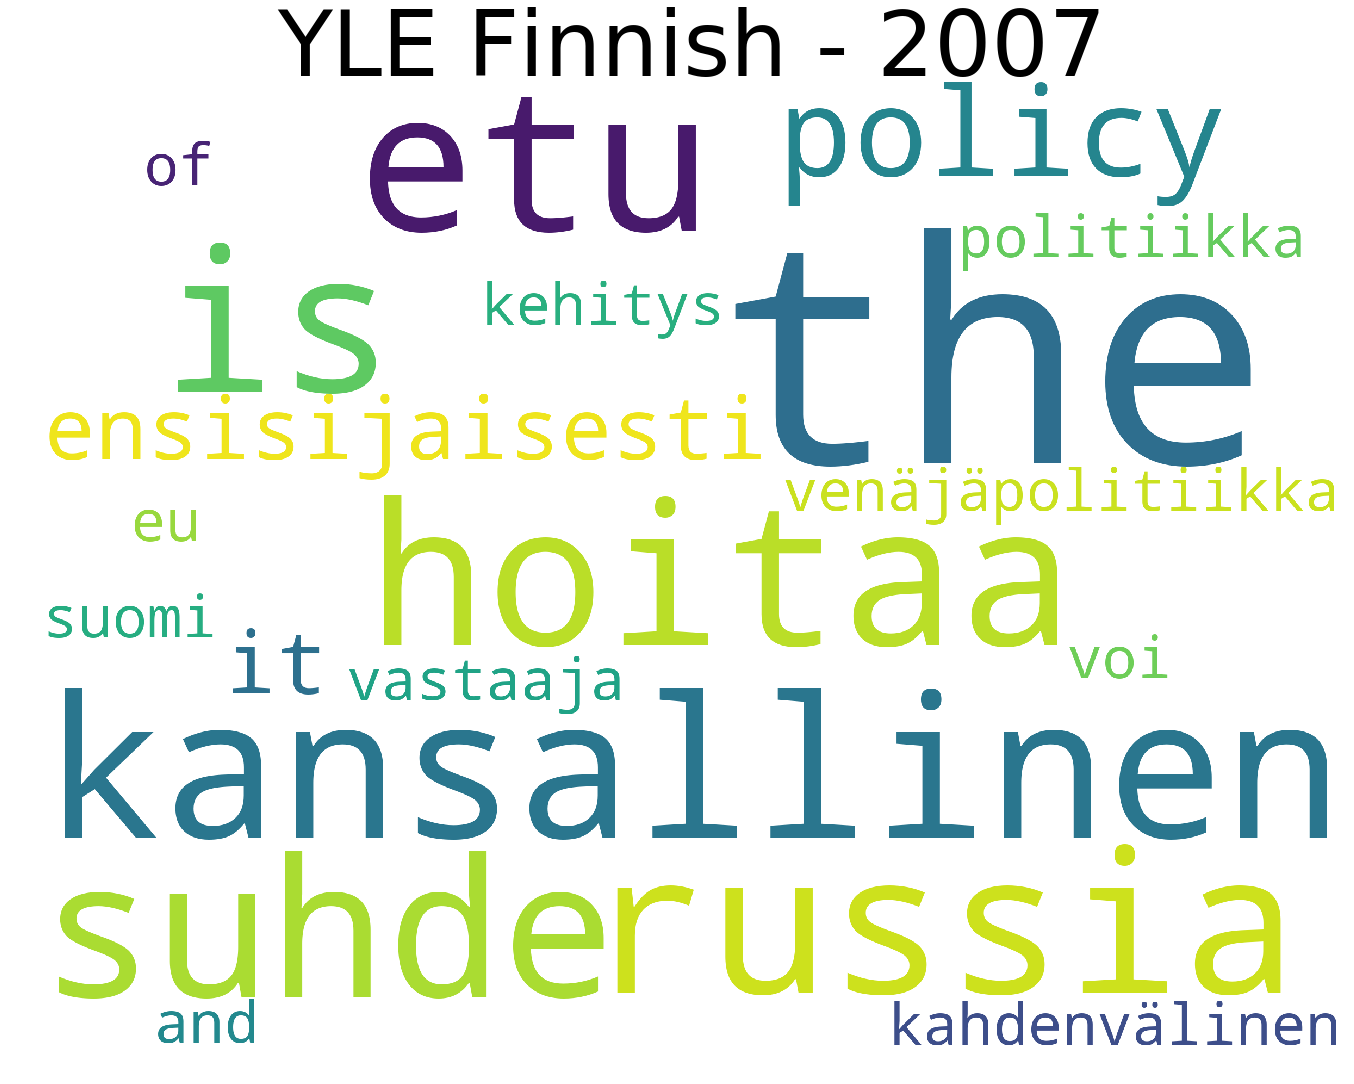

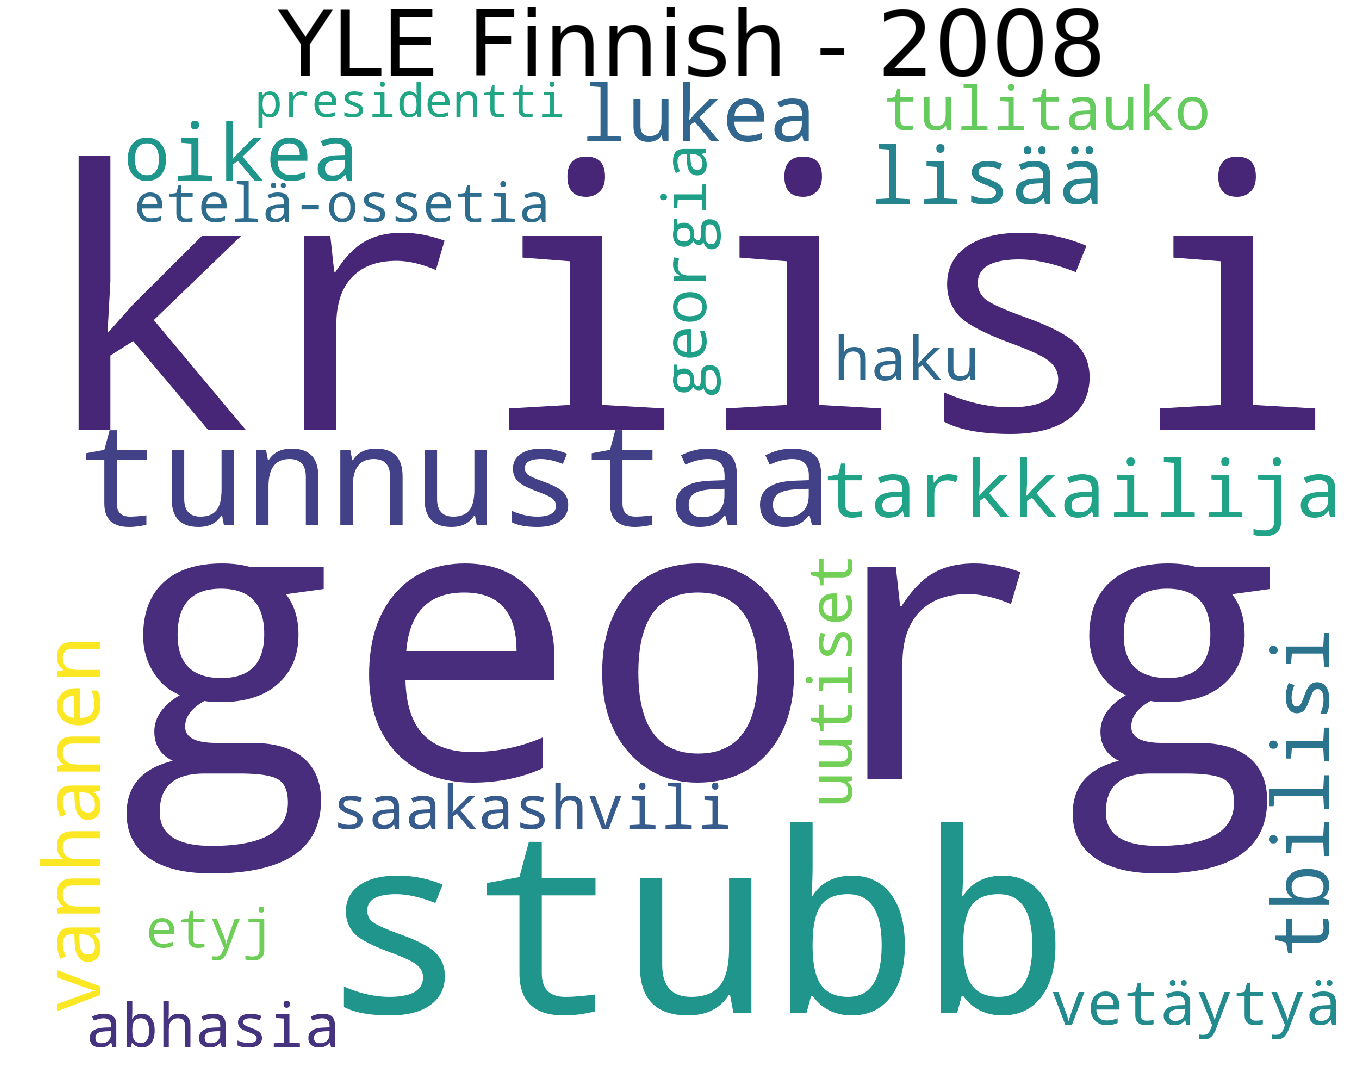

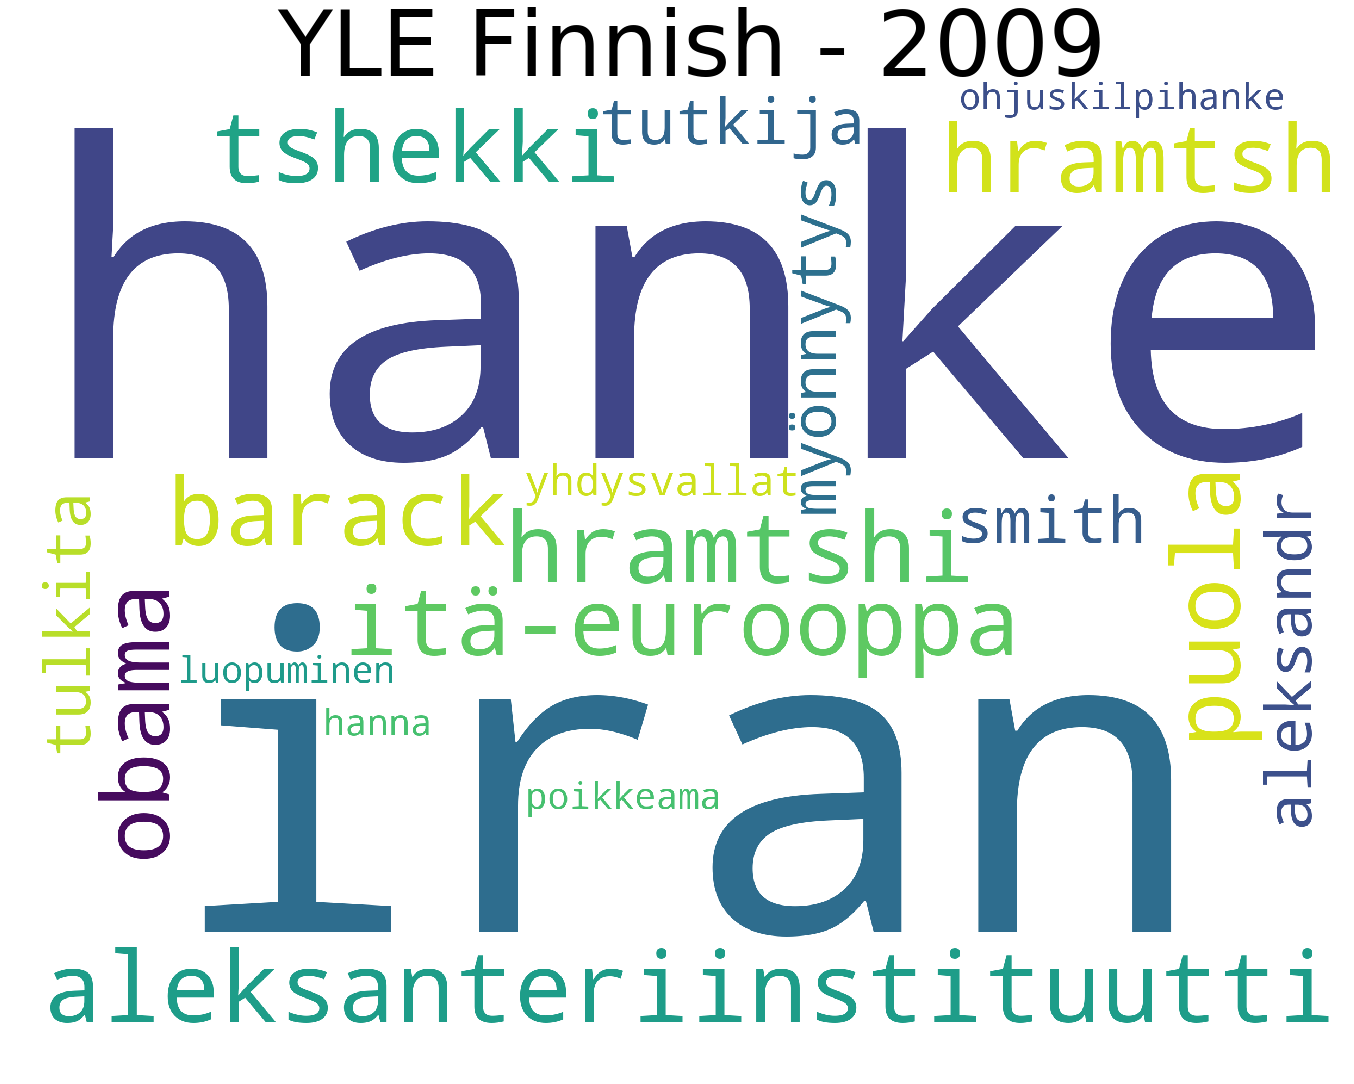

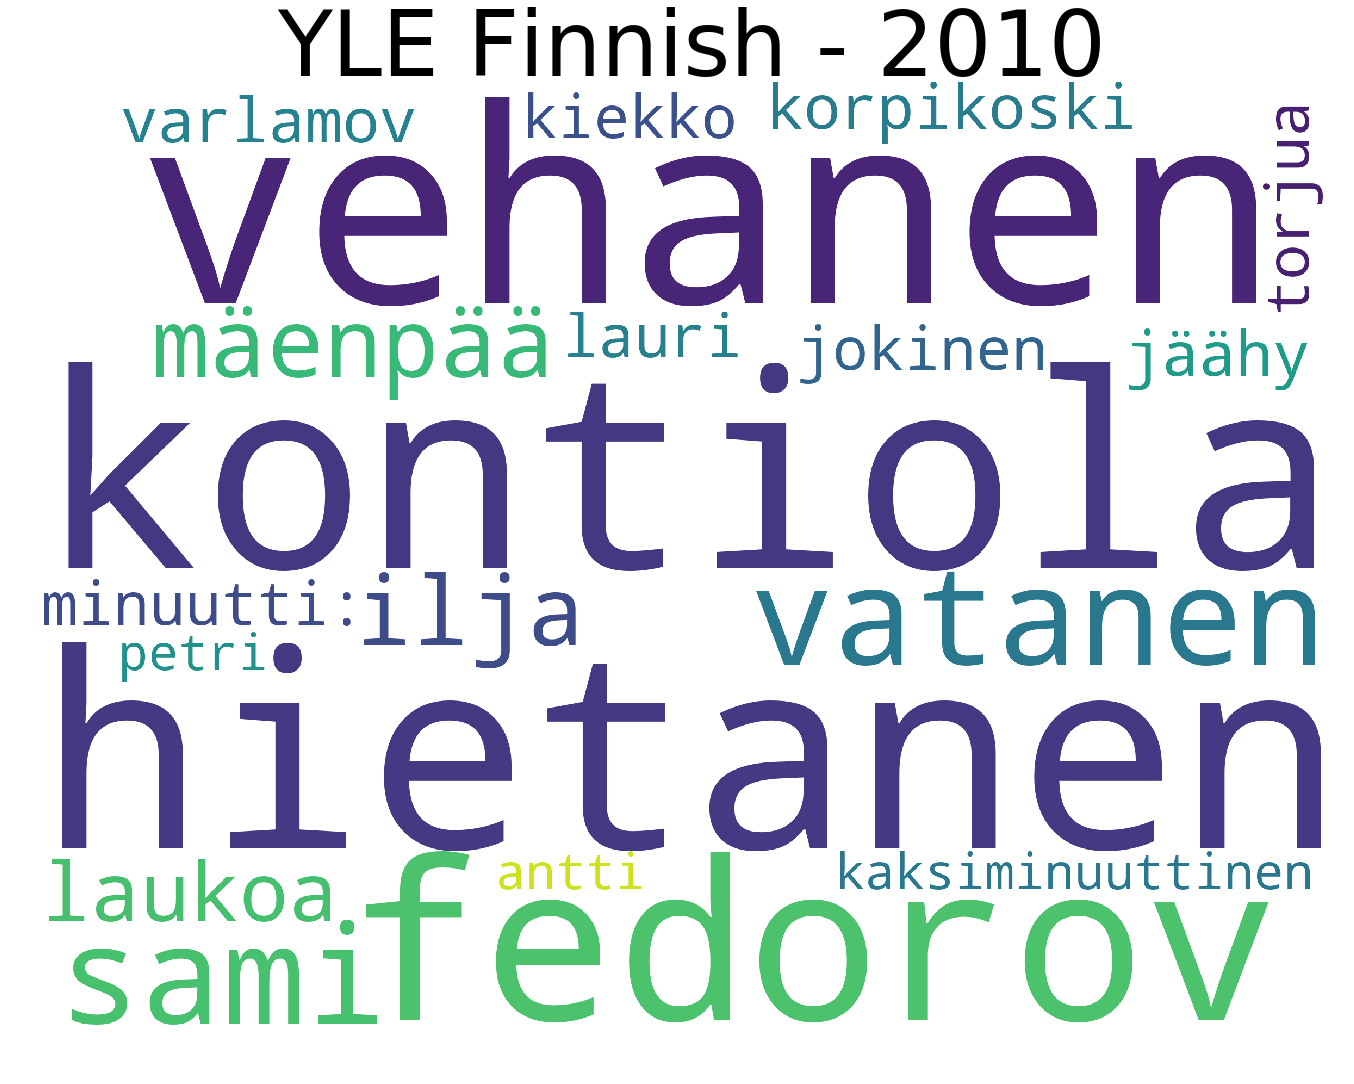

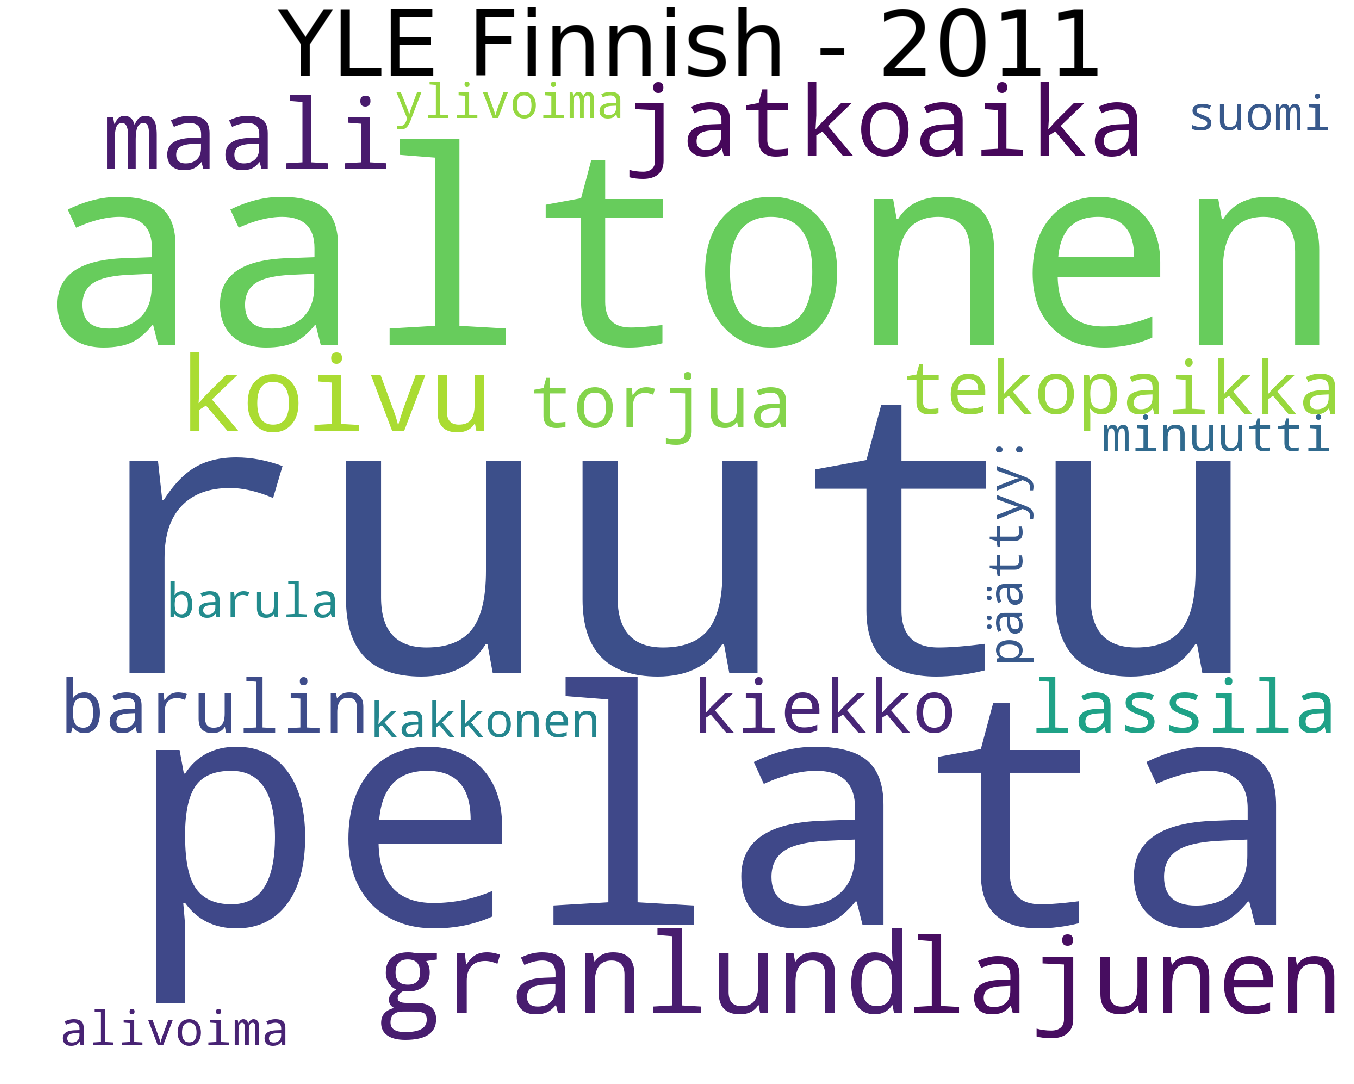

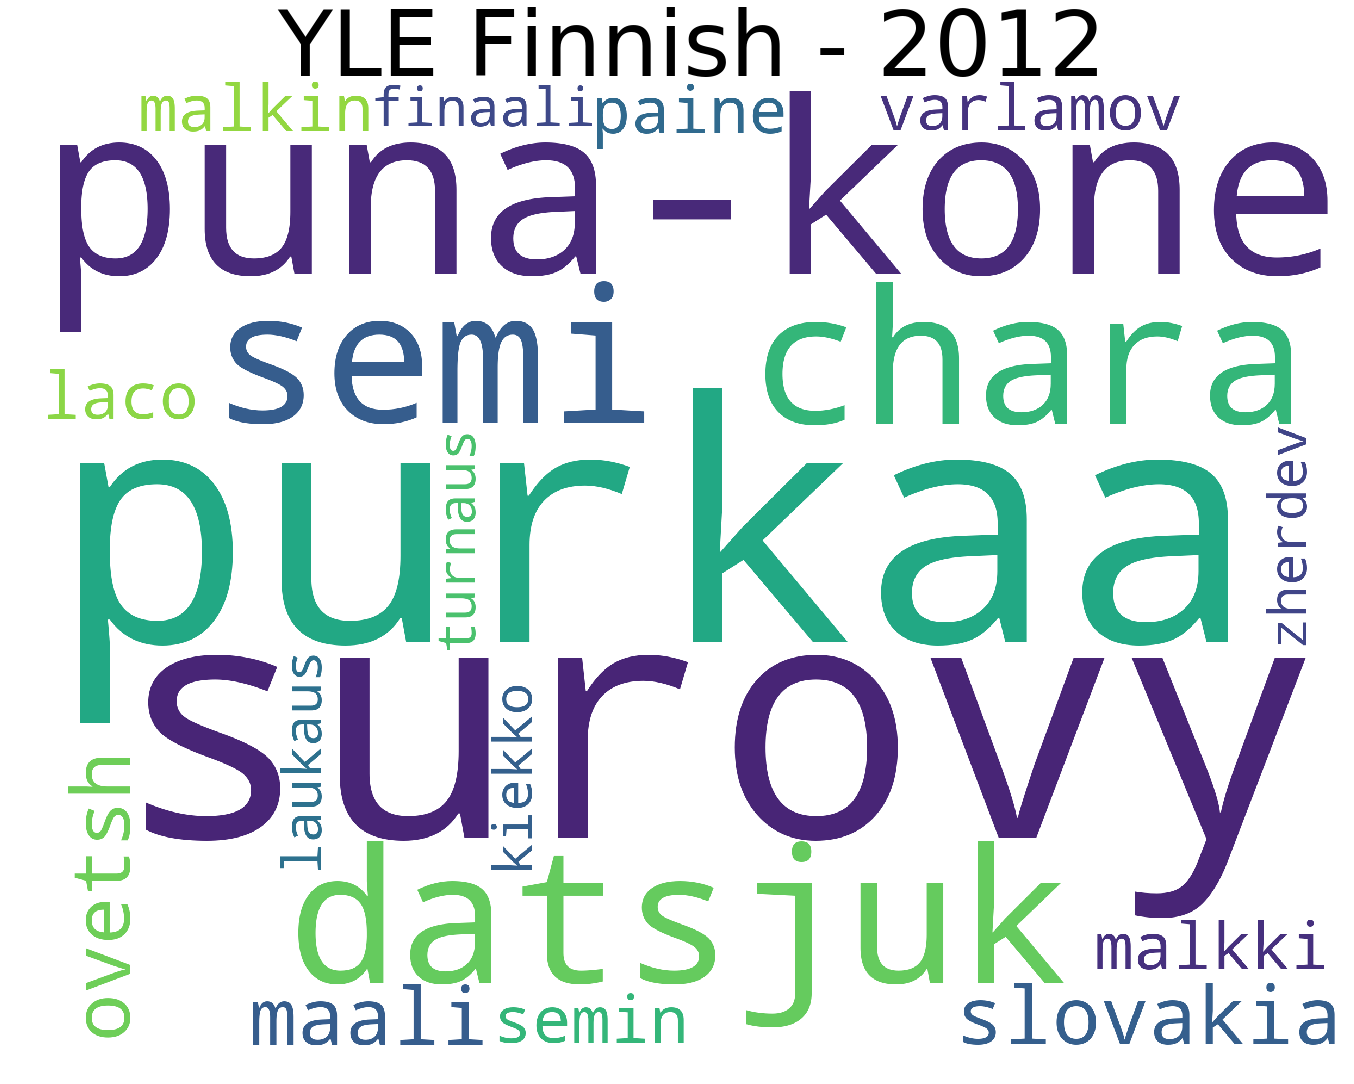

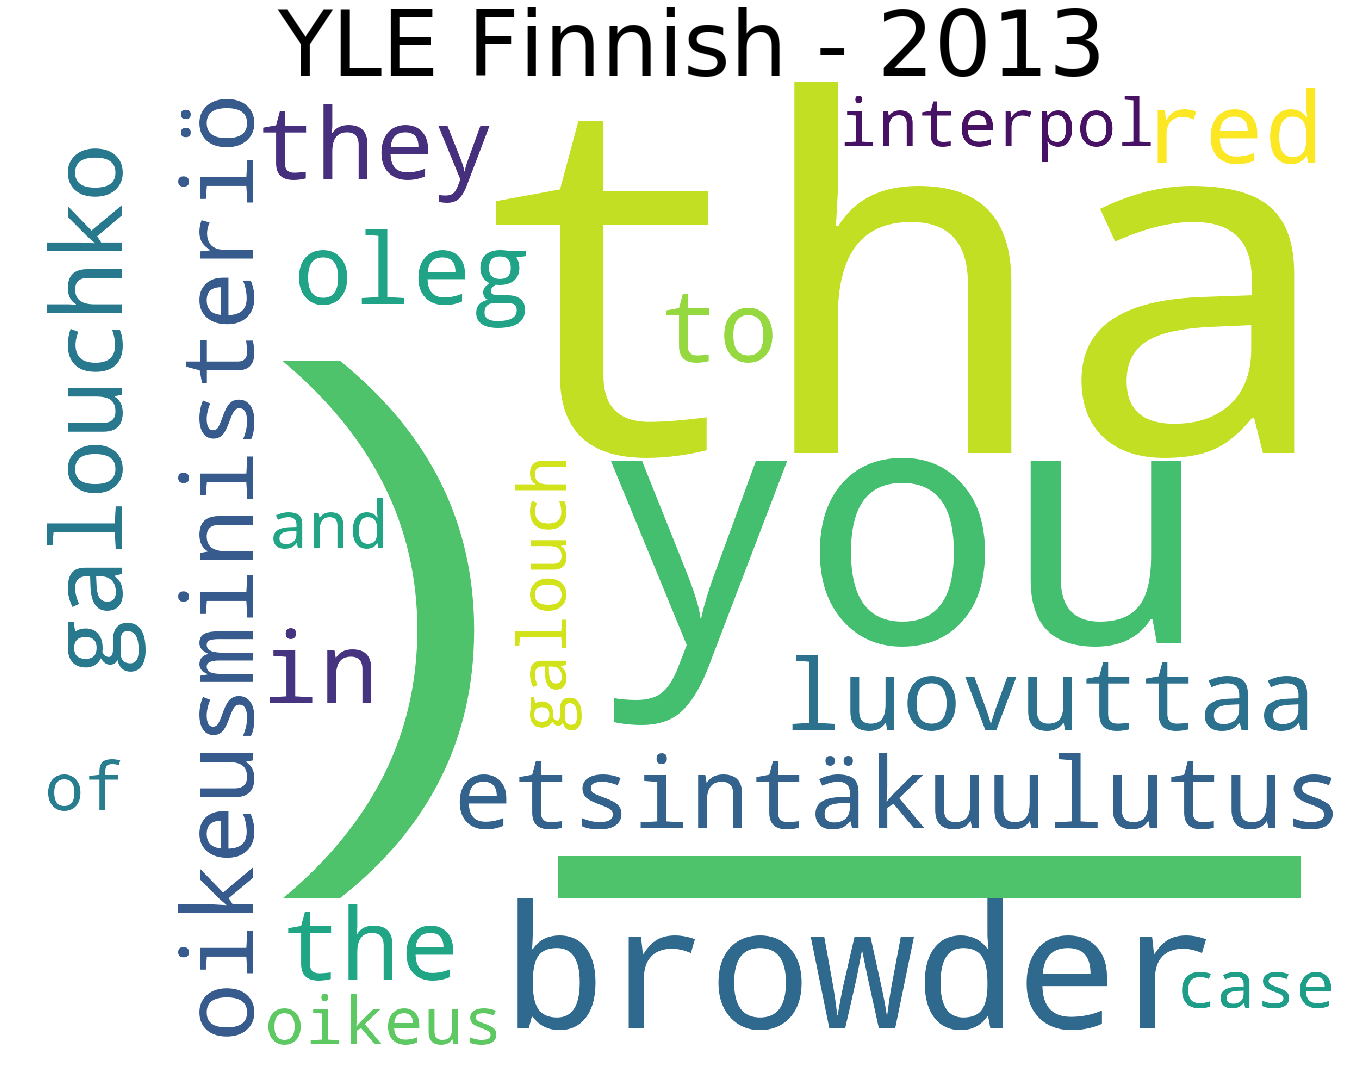

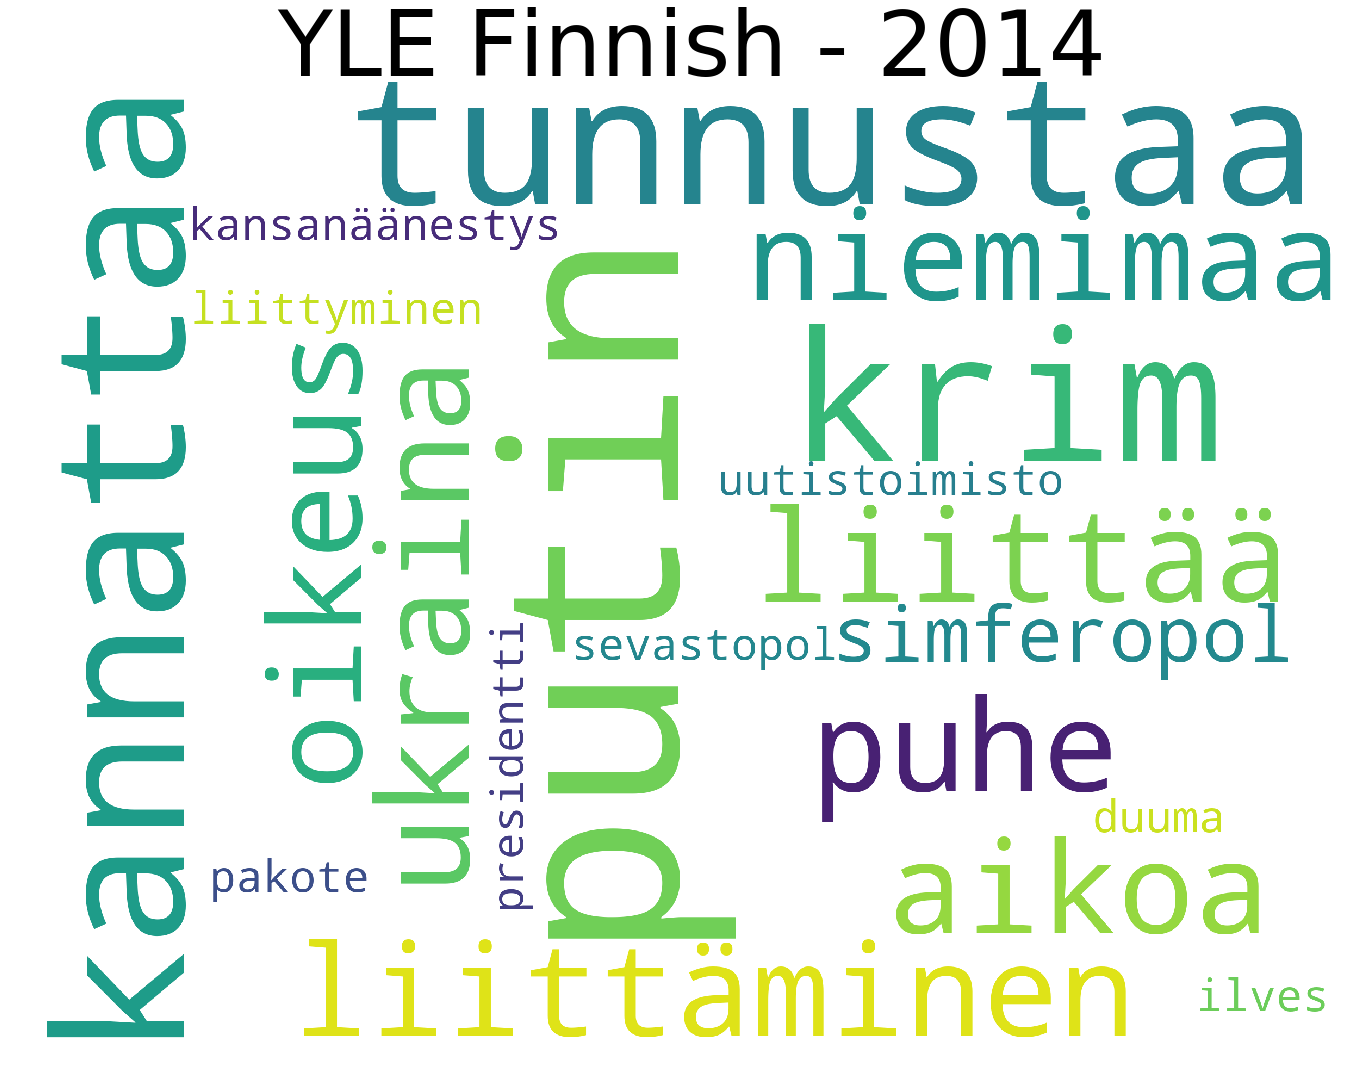

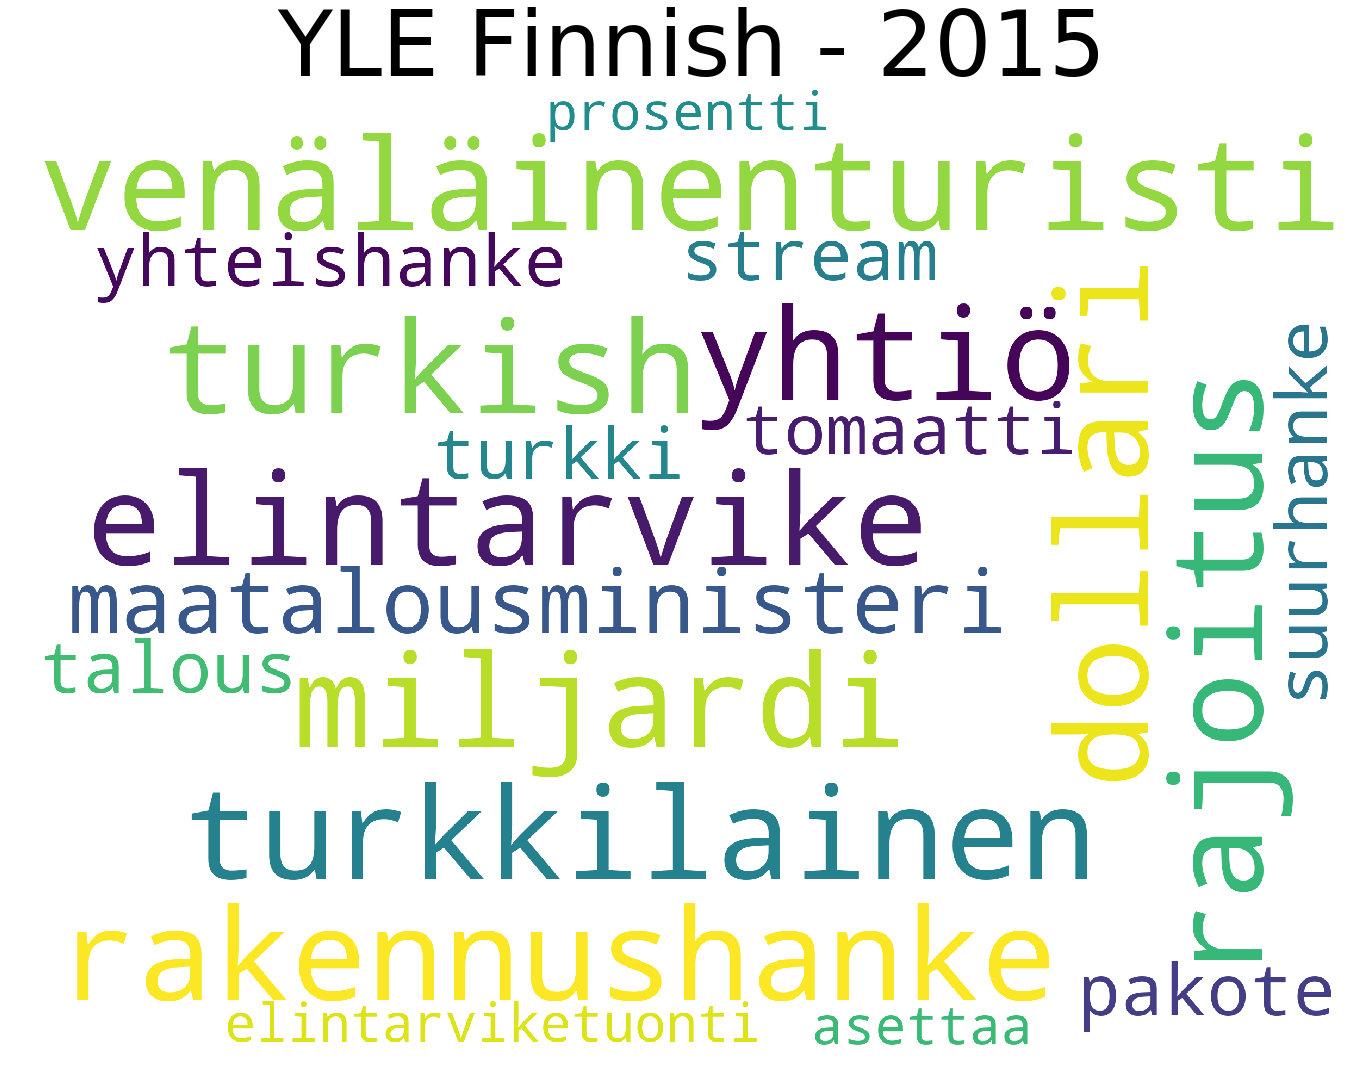

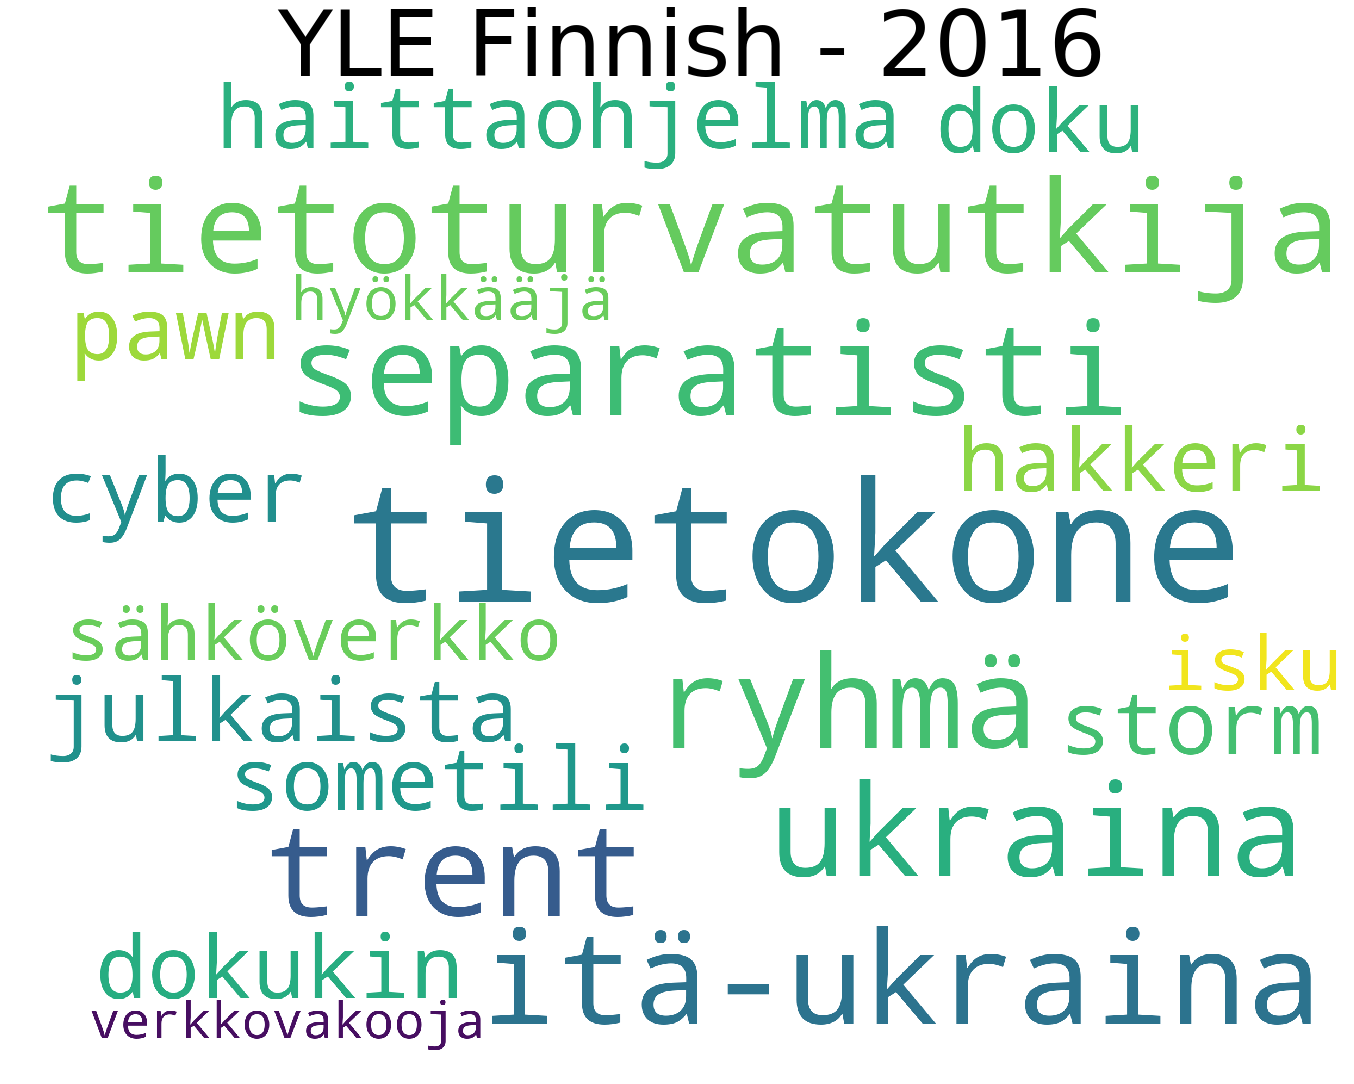

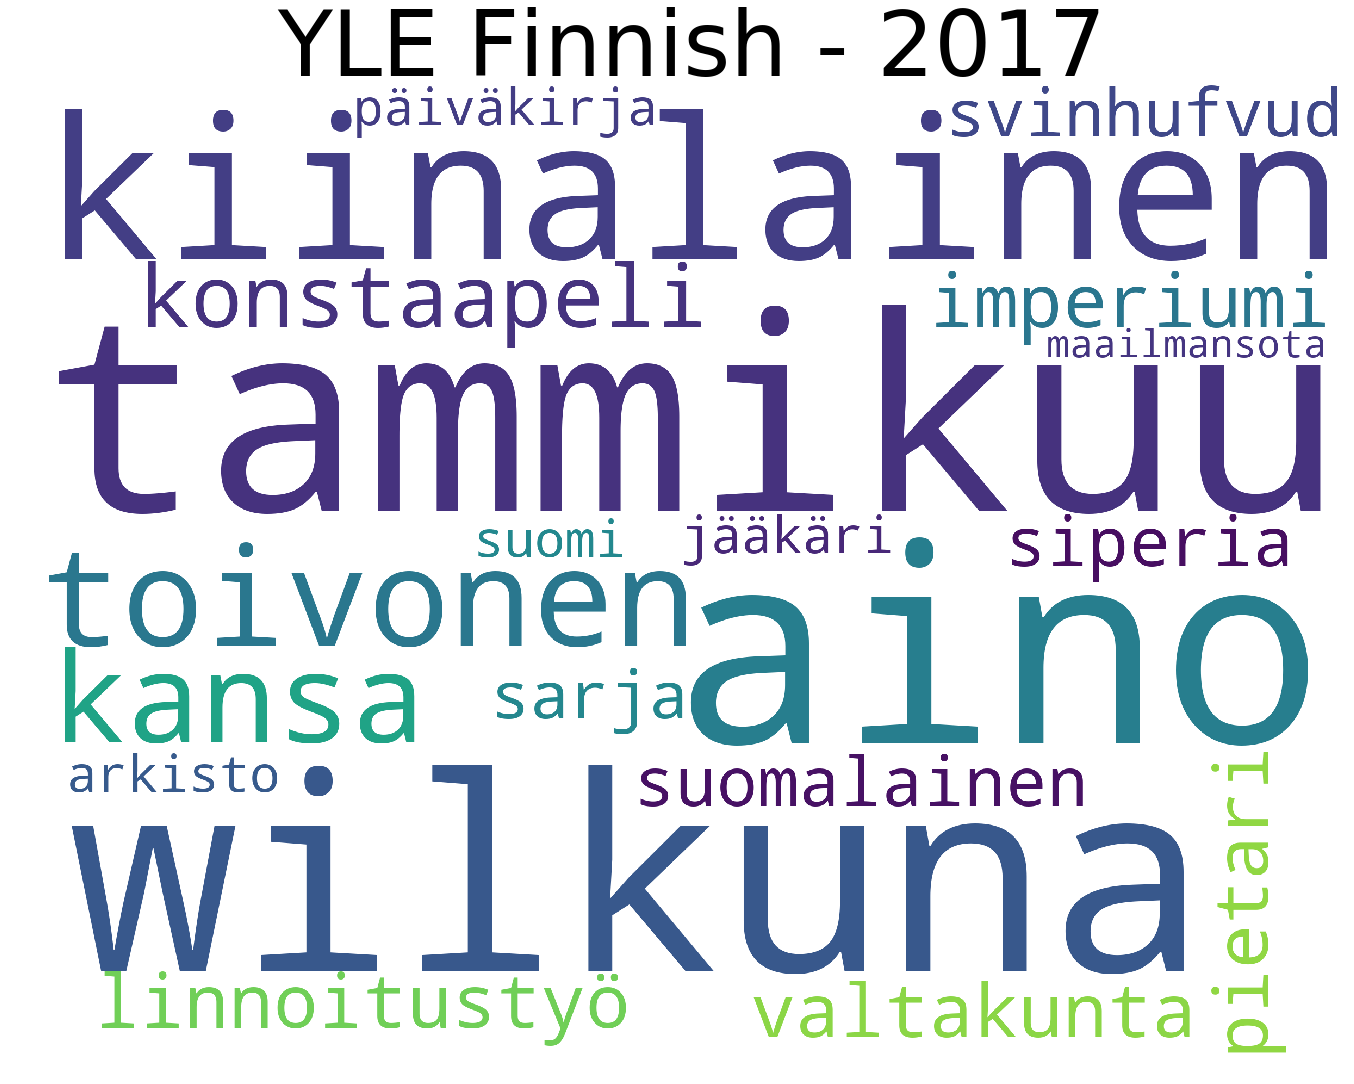

In [98]:
years = lemmas_by_year.index

for i, year in enumerate(years):
    prefix = "YLE Finnish - "
    counts = yearly_counts(top_words_yle_fi_yearly[i])  
    title = prefix + str(year)
    output_wordcloud(counts, title,  True, 'generated_images_unique_yearly/')

[1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016]